In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Загрузим данные
try:
    data_arc = pd.read_csv('data_arc.csv')    
    data_bulk = pd.read_csv('data_bulk.csv')    
    data_bulk_time = pd.read_csv('data_bulk_time.csv')    
    data_gas = pd.read_csv('data_gas.csv')    
    data_temp = pd.read_csv('data_temp.csv')    
    data_wire = pd.read_csv('data_wire.csv')
    data_wire_time = pd.read_csv('data_wire_time.csv')    
except:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

data_arc.name = 'data_arc'
data_bulk.name = 'data_bulk'
data_bulk_time.name = 'data_bulk_time'
data_gas.name = 'data_gas'
data_temp.name = 'data_temp'
data_wire.name = 'data_wire'
data_wire_time.name = 'data_wire_time'

## Исследовательский анализ данных

In [3]:
# Создадим функцию для первичного анализа датасета
def get_info(data):
    try:
        print(f'Информация о датасете {data.name}:')
    except:
        pass
    print("Общий вид датасета")
    display(data.head(5))
    print('='*50)
    print('Описание столбцов')
    display(data.info())
    print('='*50)
    print('Описание численных значений')
    display(data.describe())
    print('='*50)
    print('Количество пропусков, %')
    print(data.isnull().mean()*100)
    print('='*50)
    print('Количество дублей')
    print(data.duplicated().sum())
    print('='*50)
    print(f'Количество партий {data["key"].nunique()}')
    # Построим графики
    for col in data.columns:        
        if data[col].dtype == 'int64' or data[col].dtype == 'float64':
            plt.figure(figsize=(16,9))
            plt.title(col)
            data[col].plot(kind='hist')
            plt.figure(figsize=(16,9))
            plt.title(col)
            data[col].plot(kind='box')
        elif data[col].dtype == 'O':
            continue
    return

Информация о датасете data_arc:
Общий вид датасета


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


Описание столбцов
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

Описание численных значений


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Количество пропусков, %
key                     0.0
Начало нагрева дугой    0.0
Конец нагрева дугой     0.0
Активная мощность       0.0
Реактивная мощность     0.0
dtype: float64
Количество дублей
0
Количество партий 3214


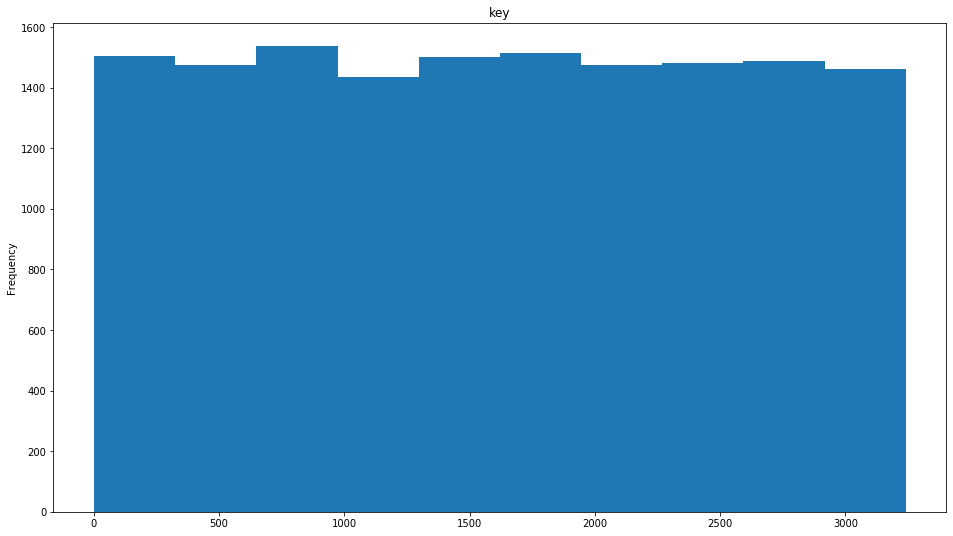

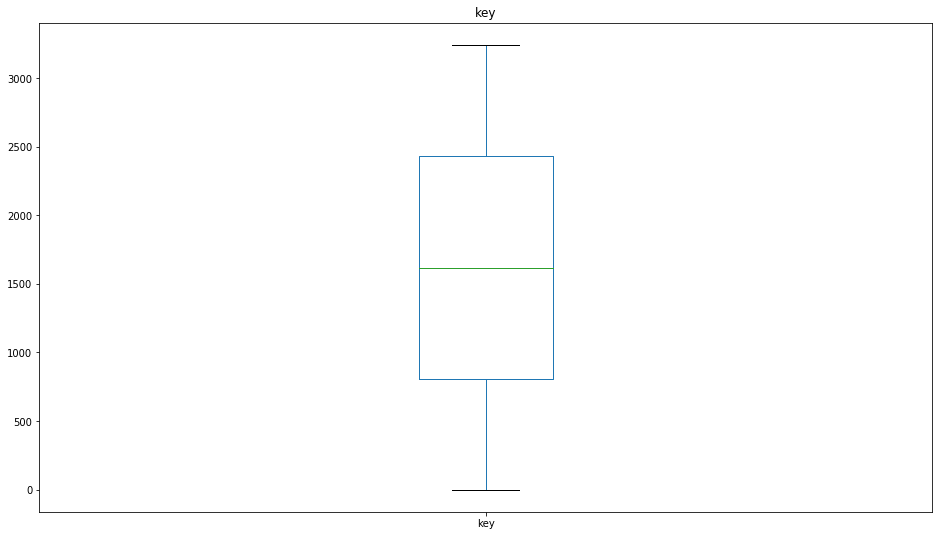

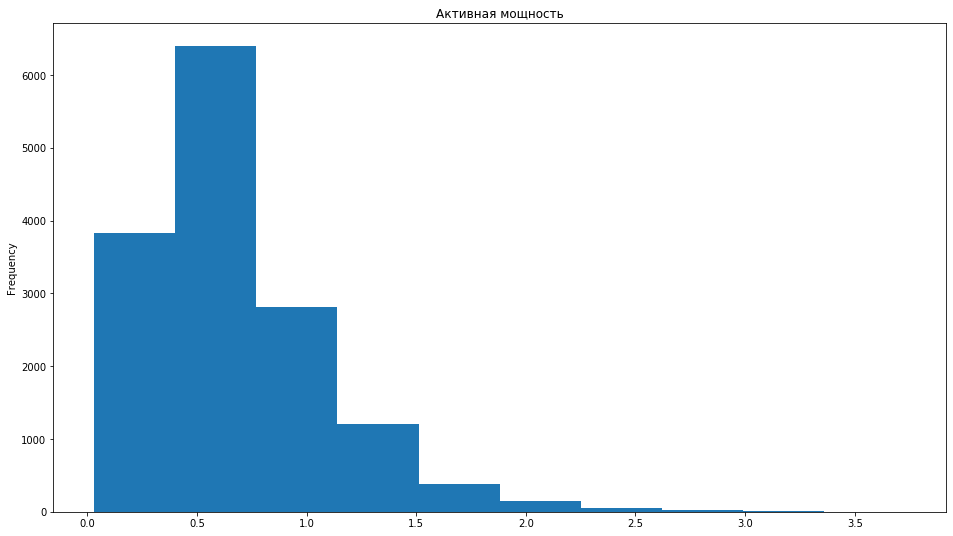

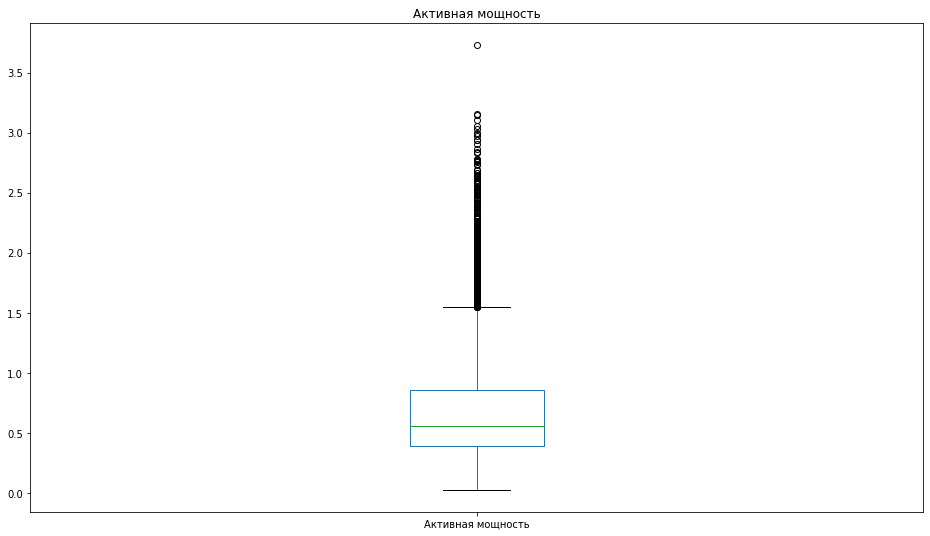

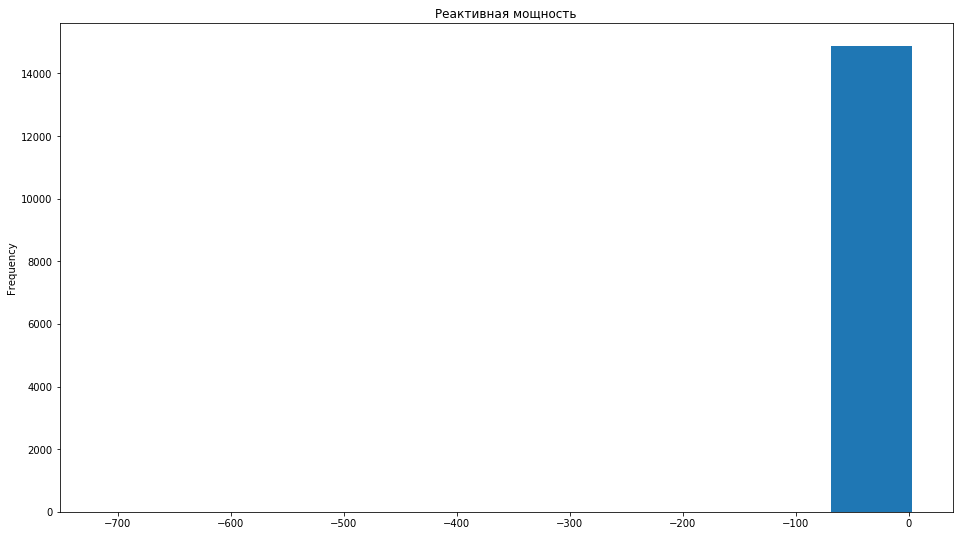

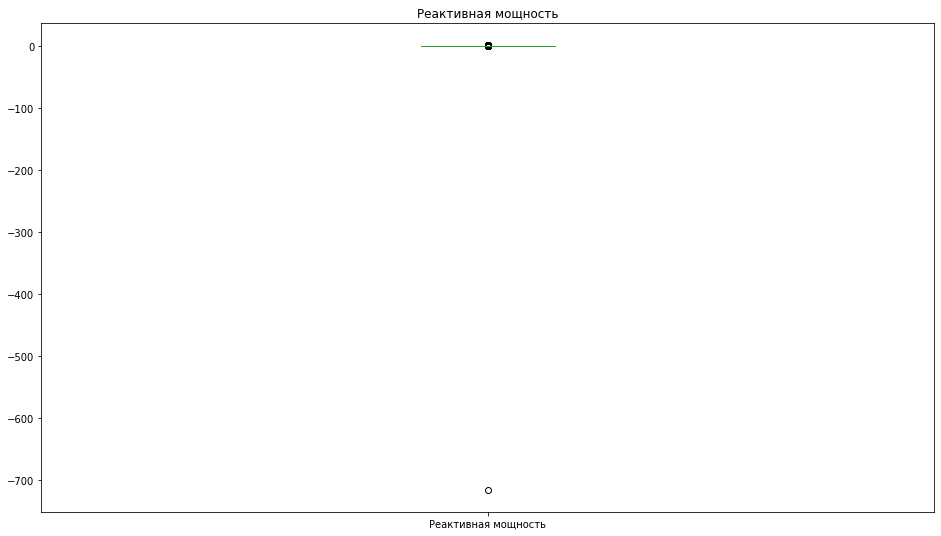

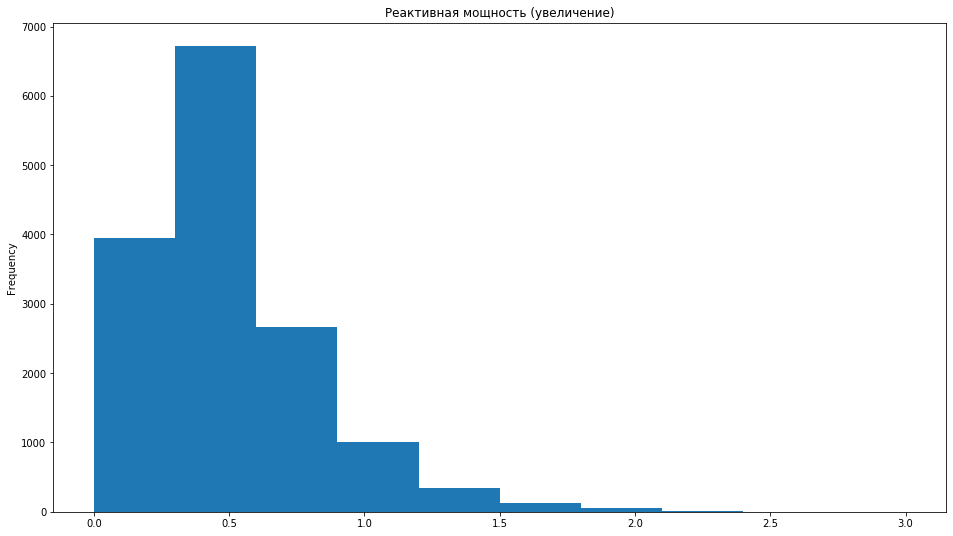

In [4]:
get_info(data_arc)
plt.figure(figsize=(16,9))
plt.title("Реактивная мощность (увеличение)")
data_arc['Реактивная мощность'].plot(kind='hist', range=(0, 3))

**Выводы:** 
- Столбец "Реактивная мощность" имеет нефизичный выброс в виде отрицательного значения. 
- Оба столбца мощности имеют тяжелый правый хвост
- Пропусков нет
- Дублей нет
- Есть выбросы

**Что сделать**:
- Обработать как большие, так и маленькие выбросы
- Изменить тип данных с *object* на *datetime* для времени
- Рассчитать полную мощность и разные энергии для каждой партии
- При подготовке признаков выбрать какую именно энергию использовать как признак

Информация о датасете data_bulk:
Общий вид датасета


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Описание столбцов
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

Описание численных значений


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Количество пропусков, %
key         0.000000
Bulk 1     91.946309
Bulk 2     99.296900
Bulk 3     58.517098
Bulk 4     67.593480
Bulk 5     97.539150
Bulk 6     81.591563
Bulk 7     99.201023
Bulk 8     99.968041
Bulk 9     99.392777
Bulk 10    94.375200
Bulk 11    94.343241
Bulk 12    21.700224
Bulk 13    99.424736
Bulk 14    10.322787
Bulk 15    28.155960
dtype: float64
Количество дублей
0
Количество партий 3129


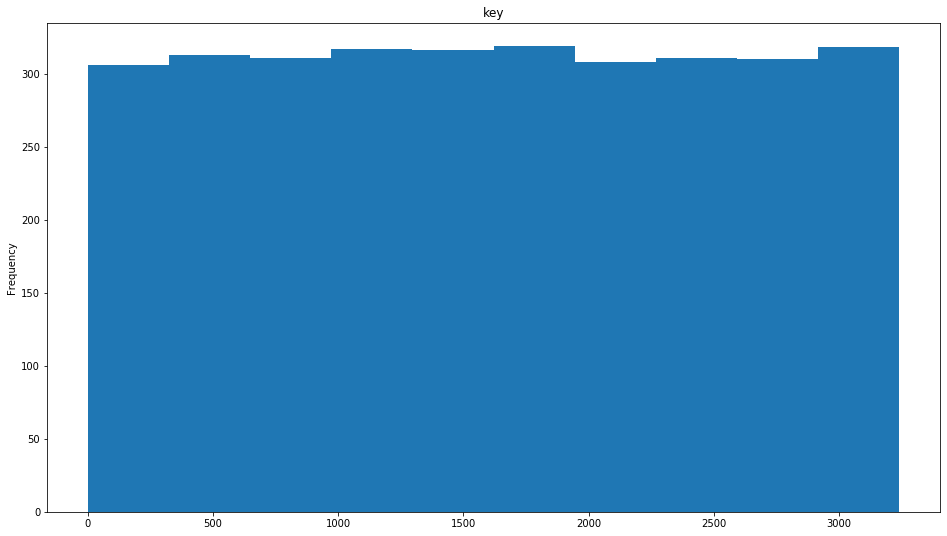

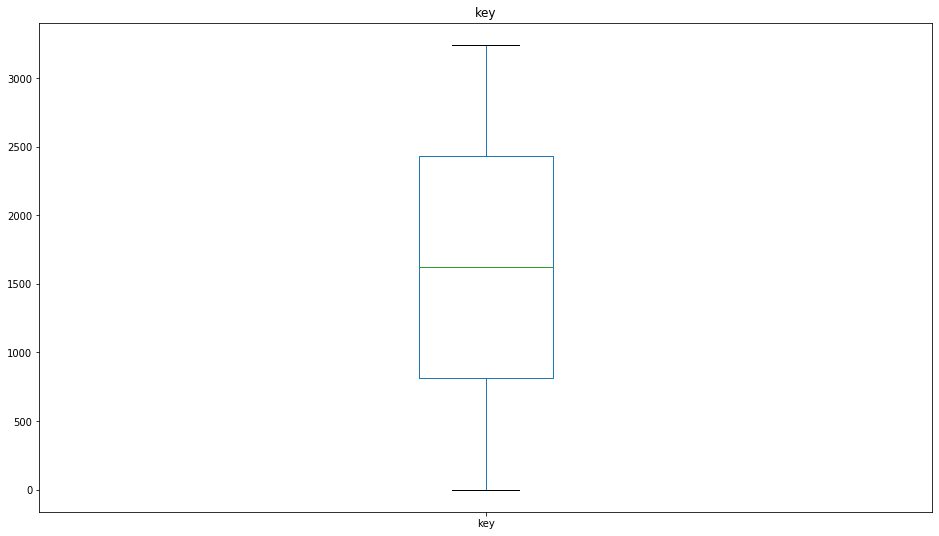

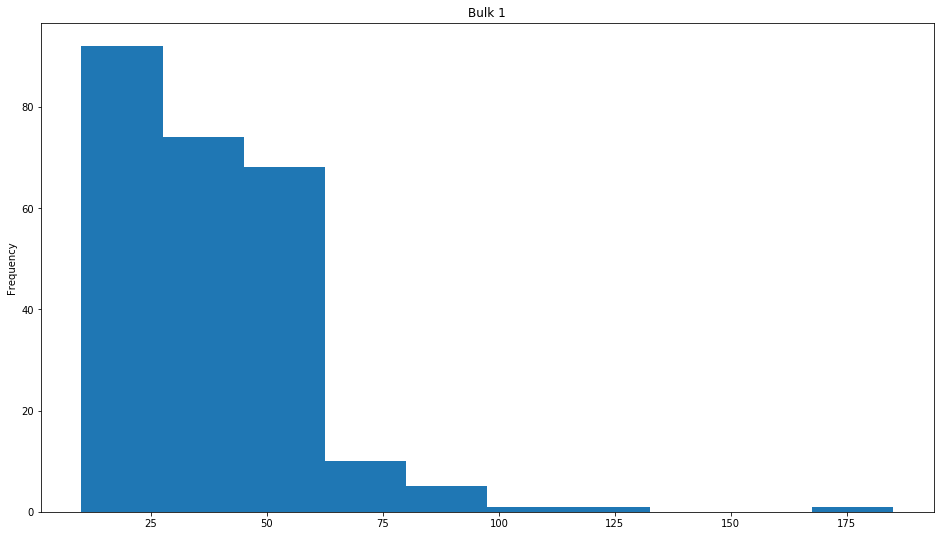

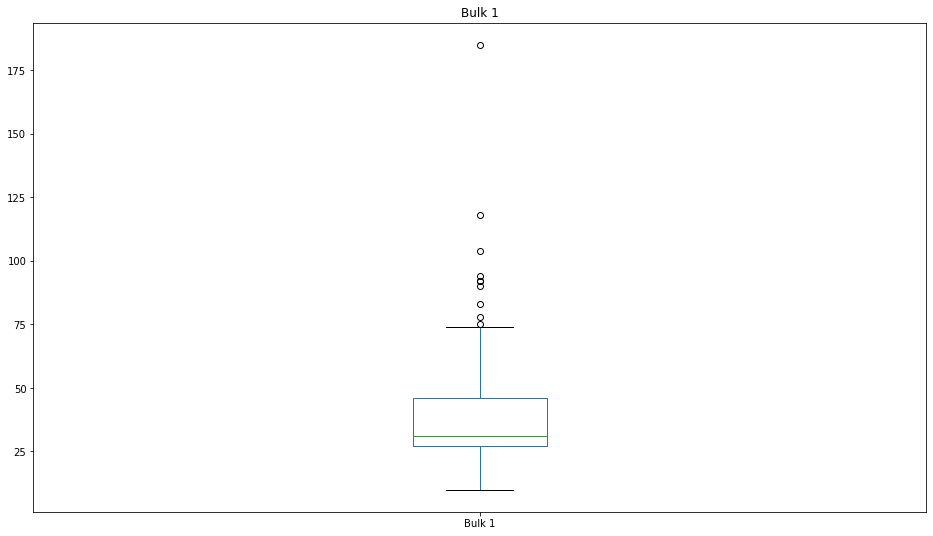

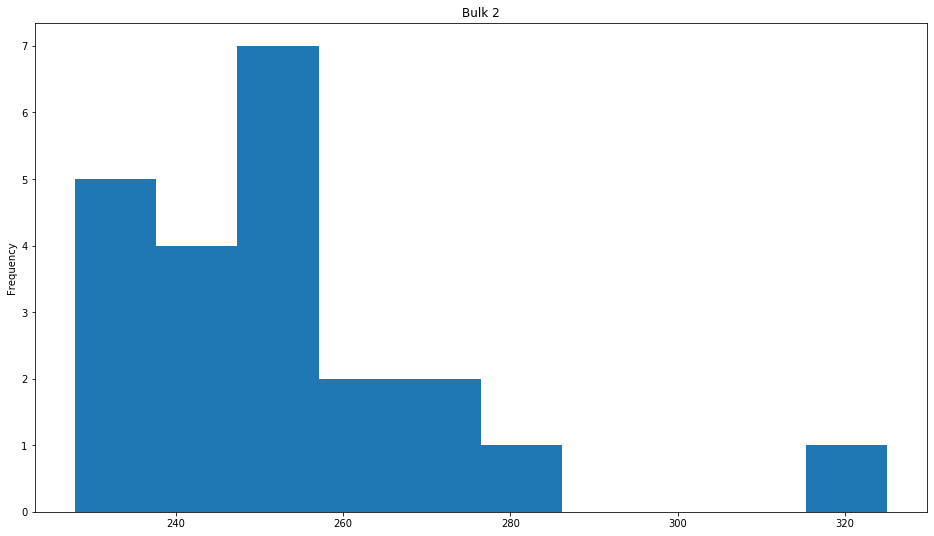

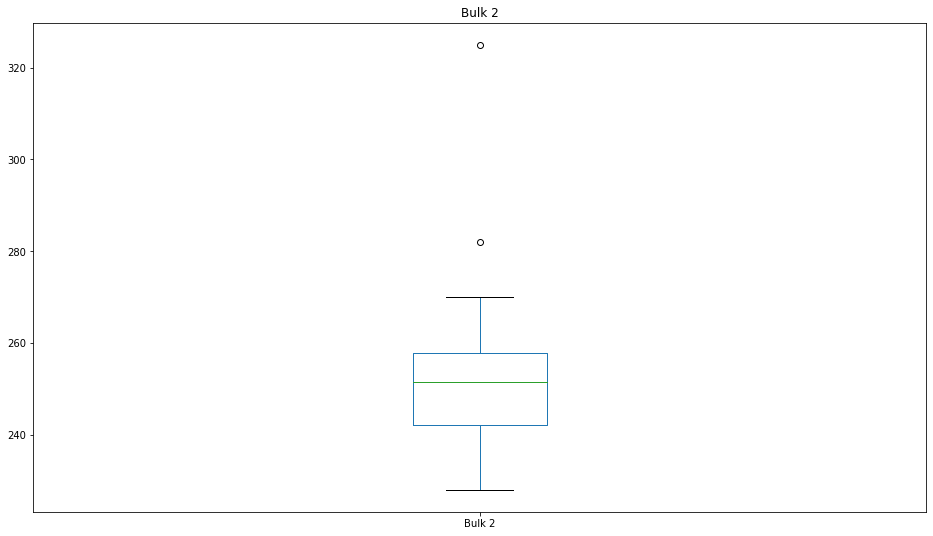

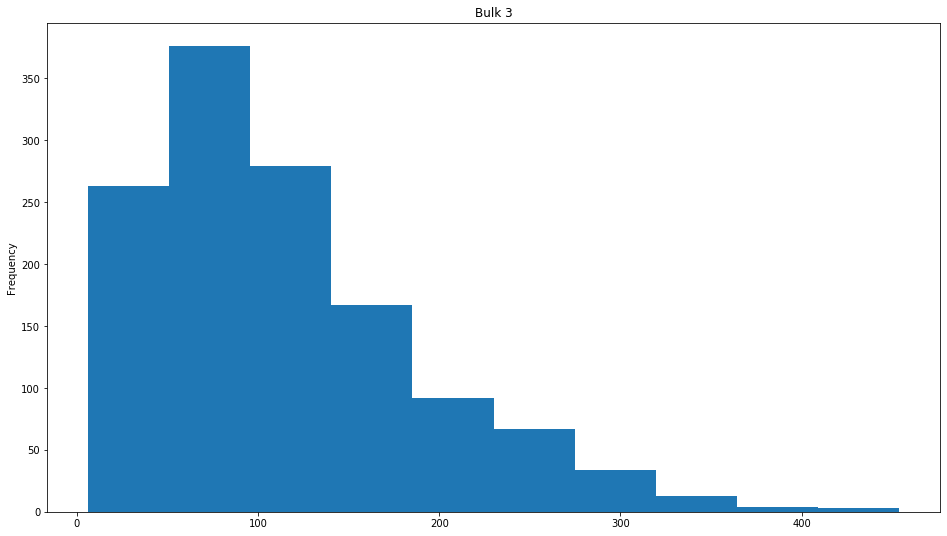

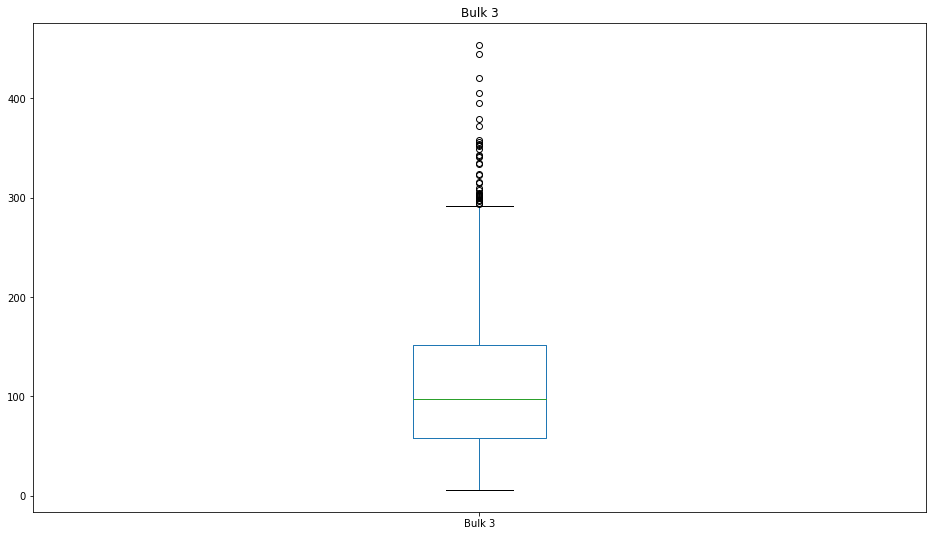

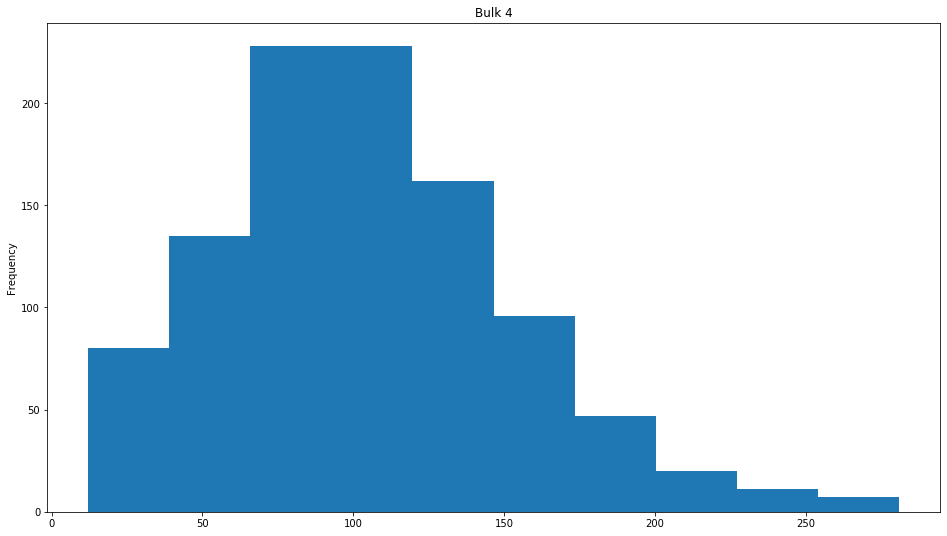

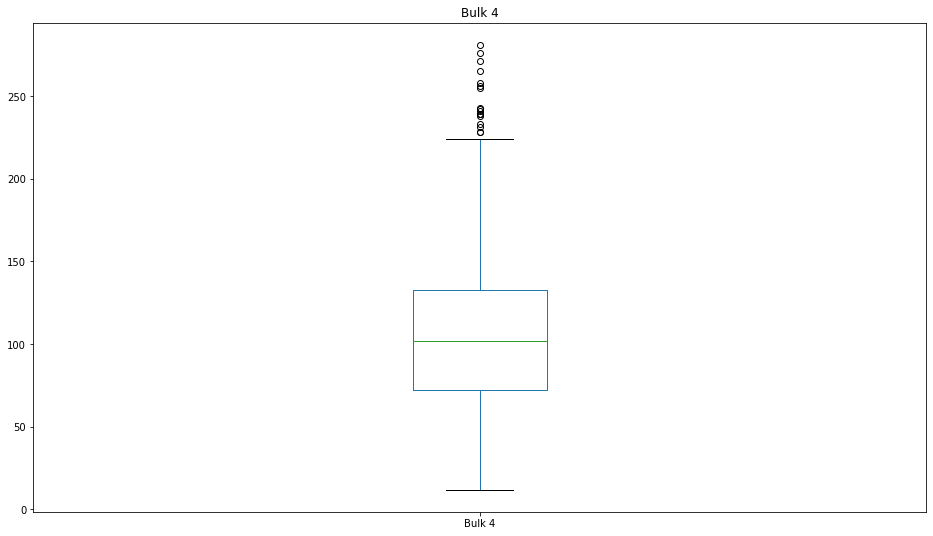

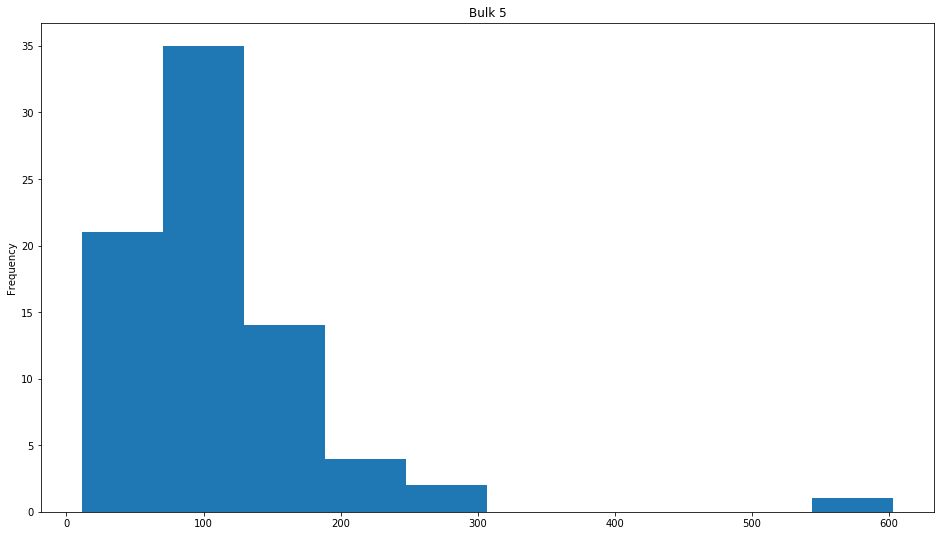

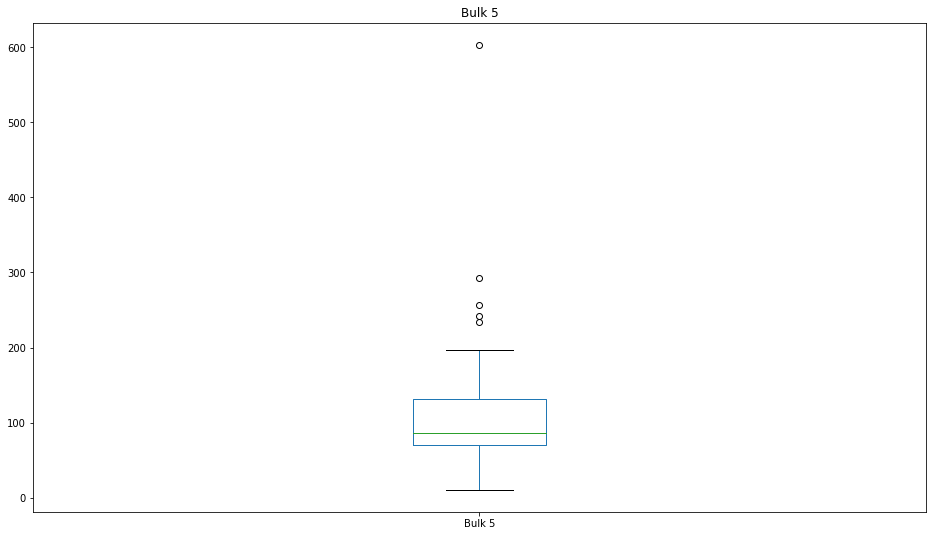

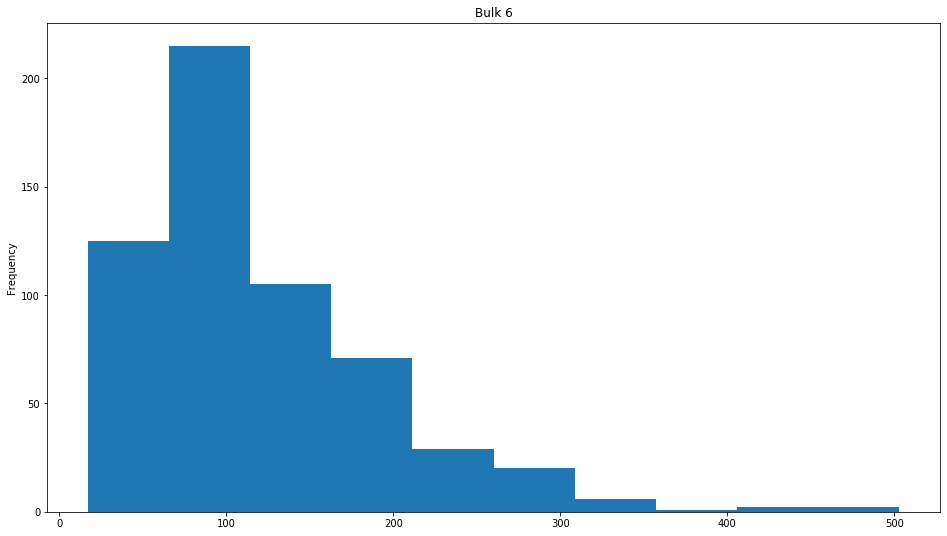

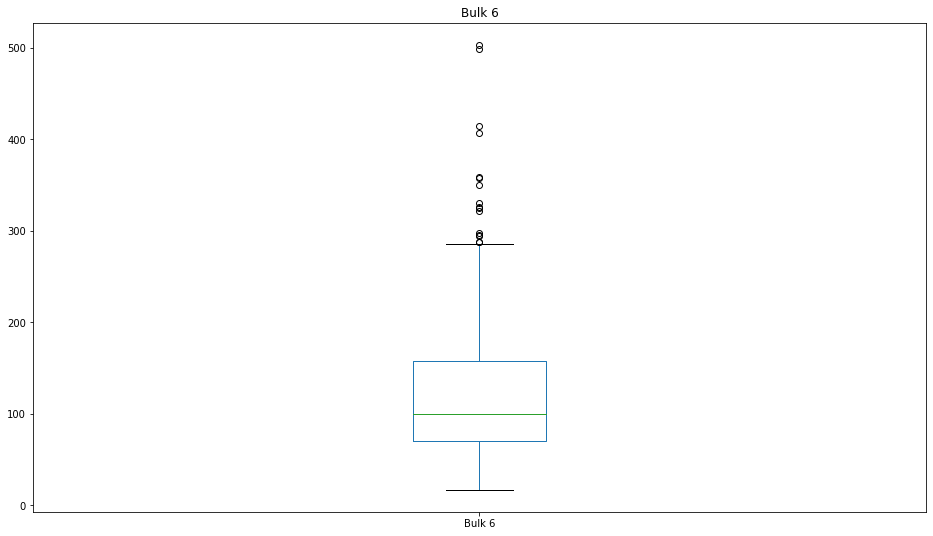

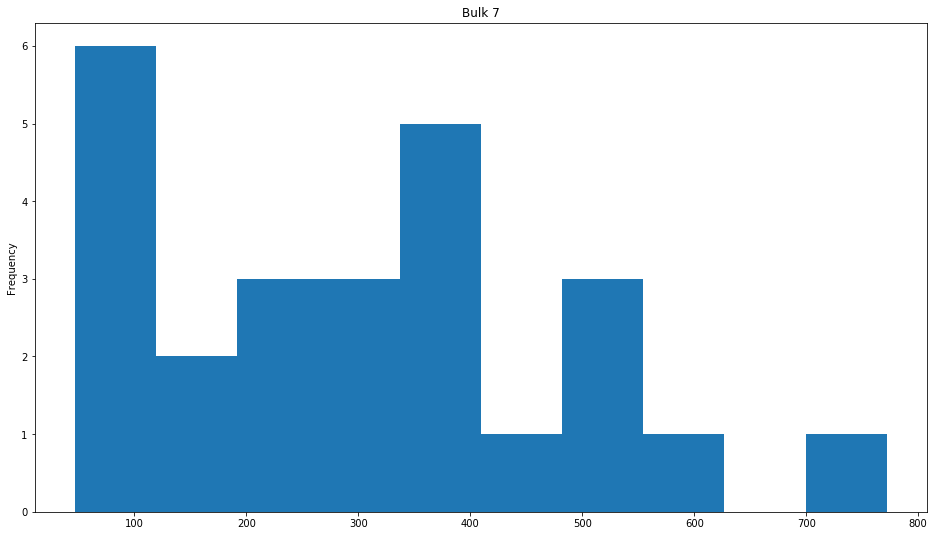

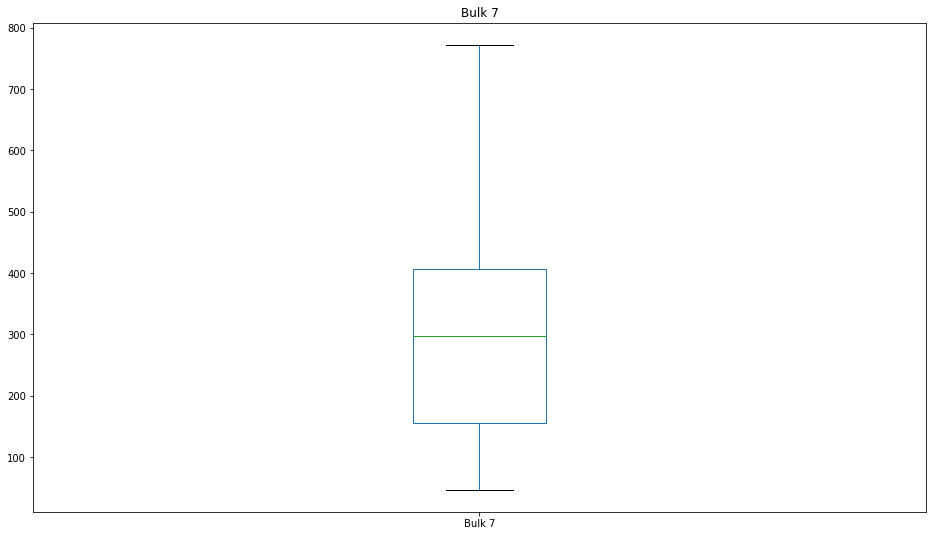

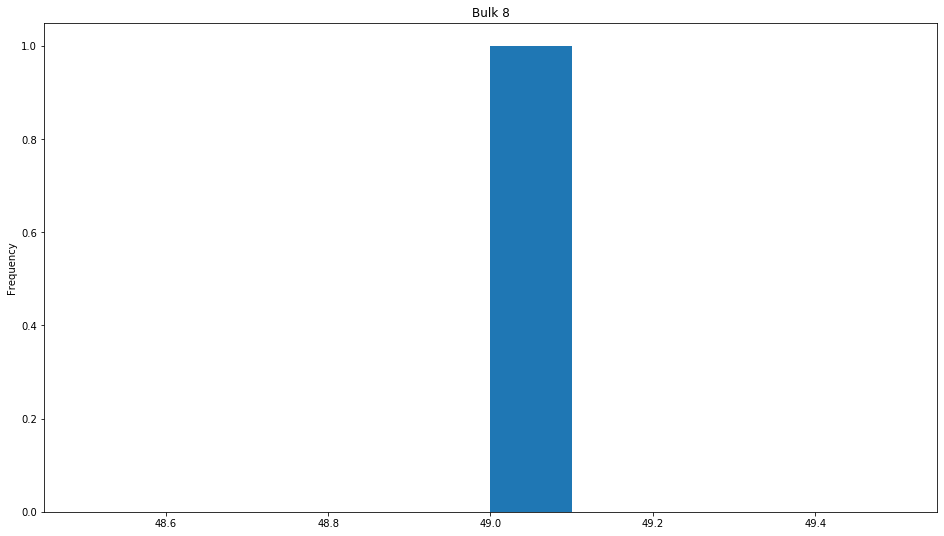

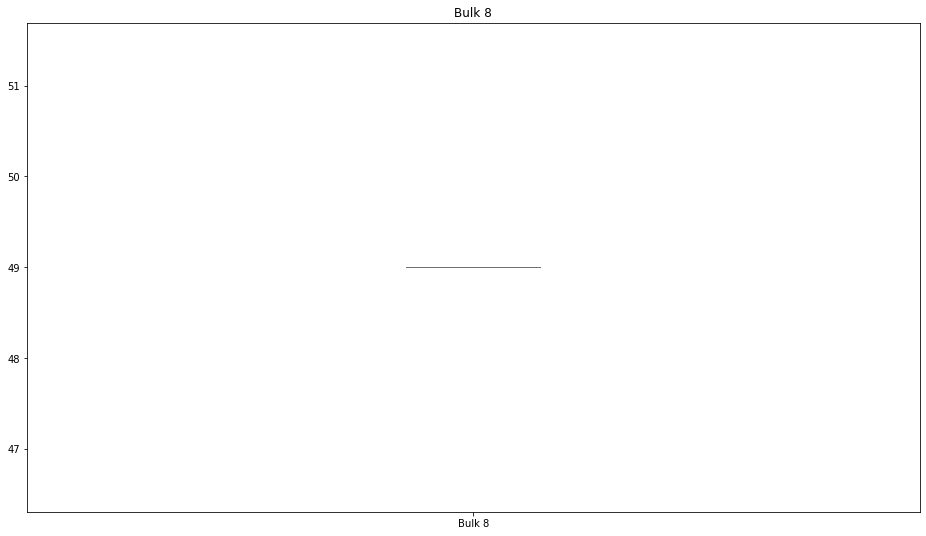

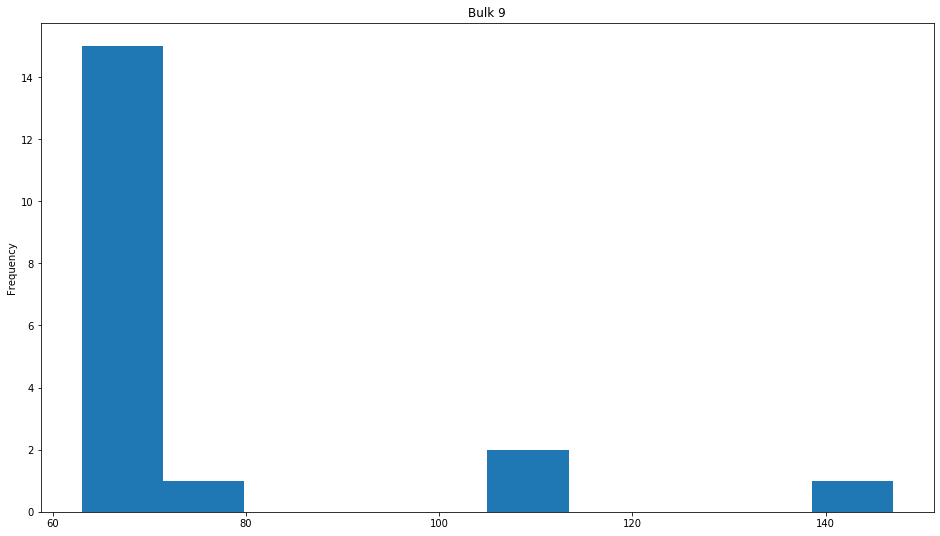

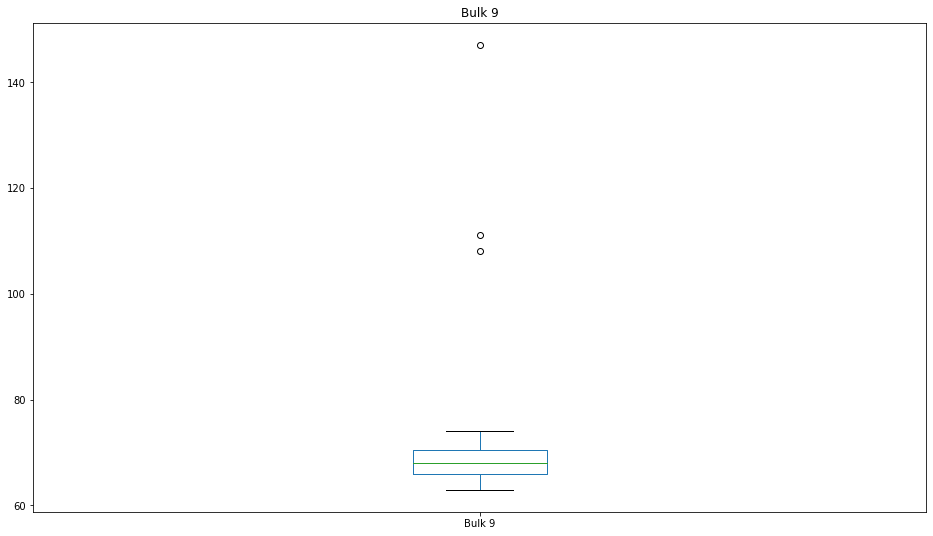

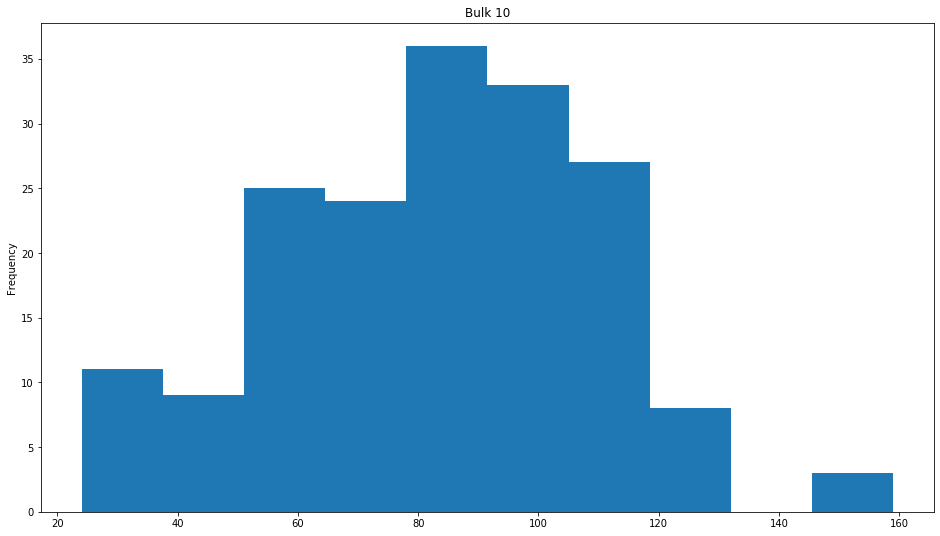

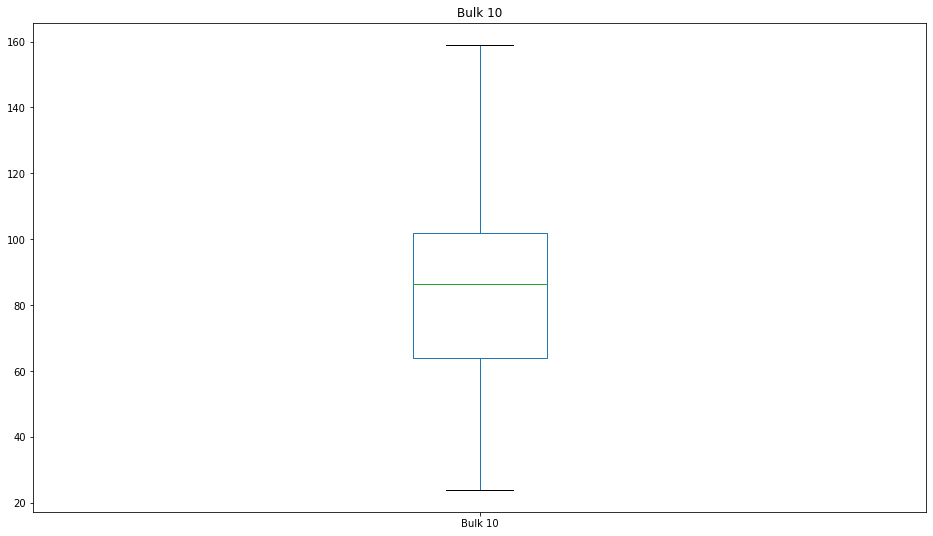

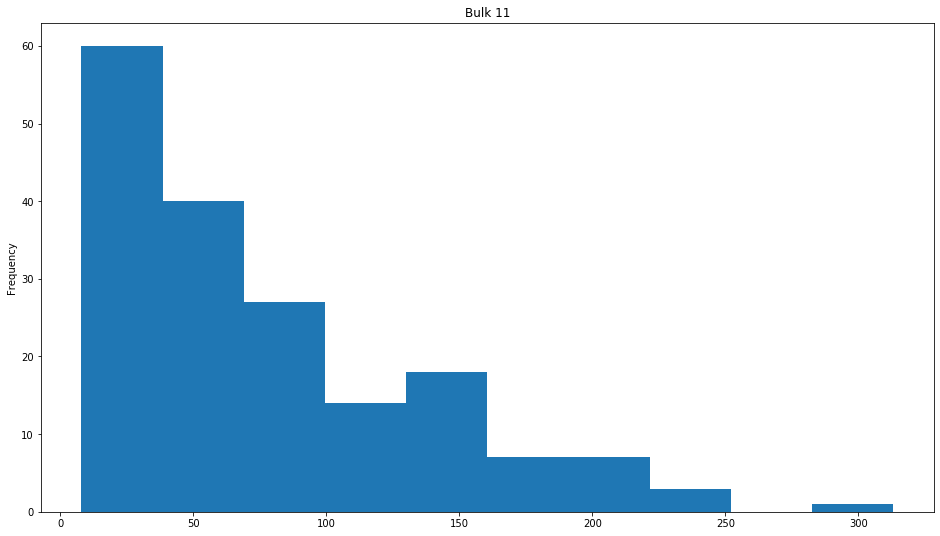

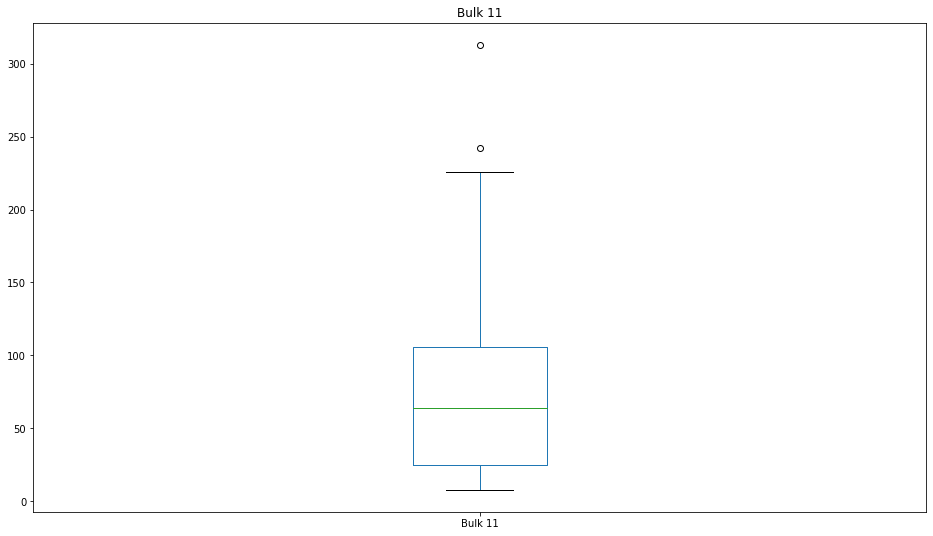

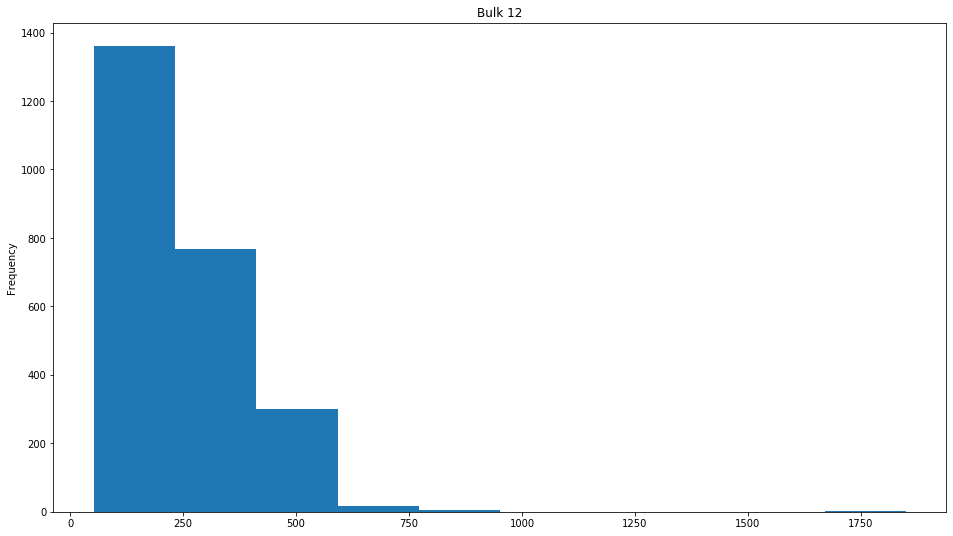

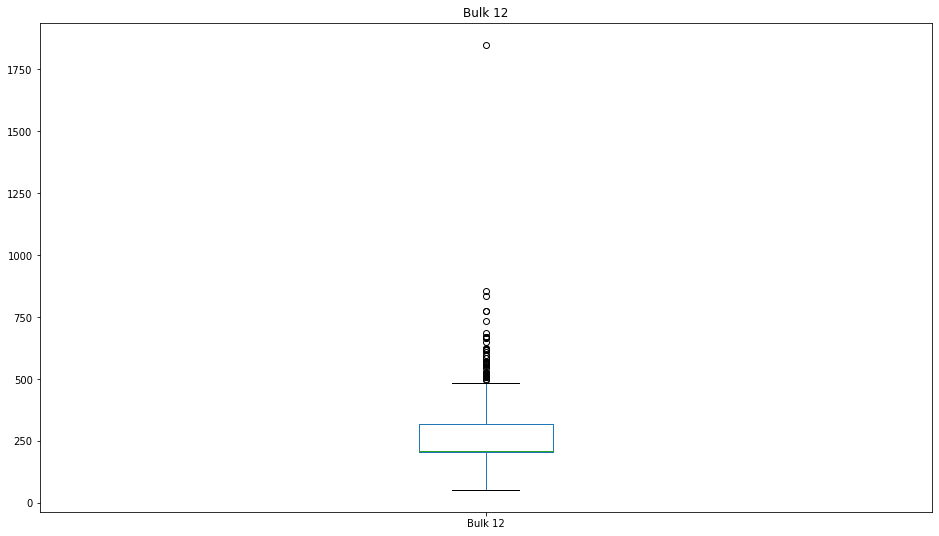

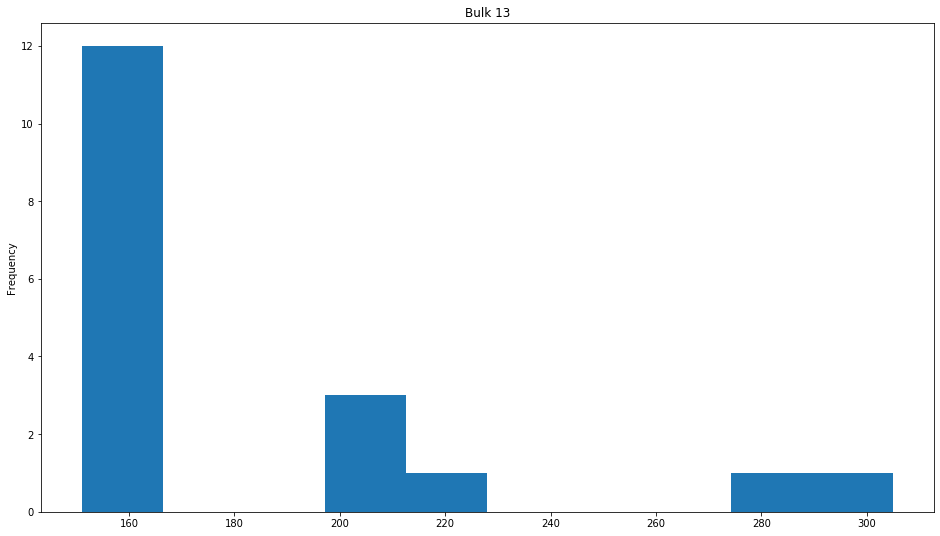

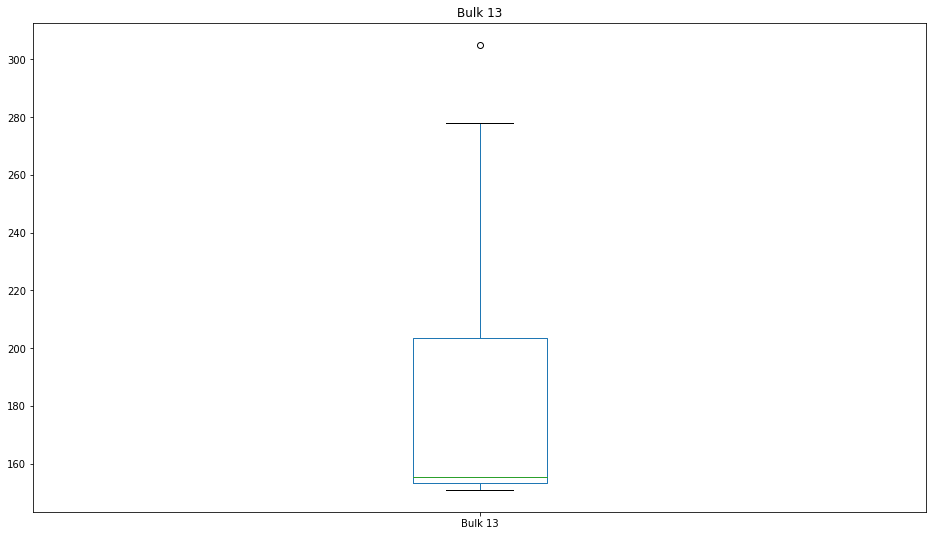

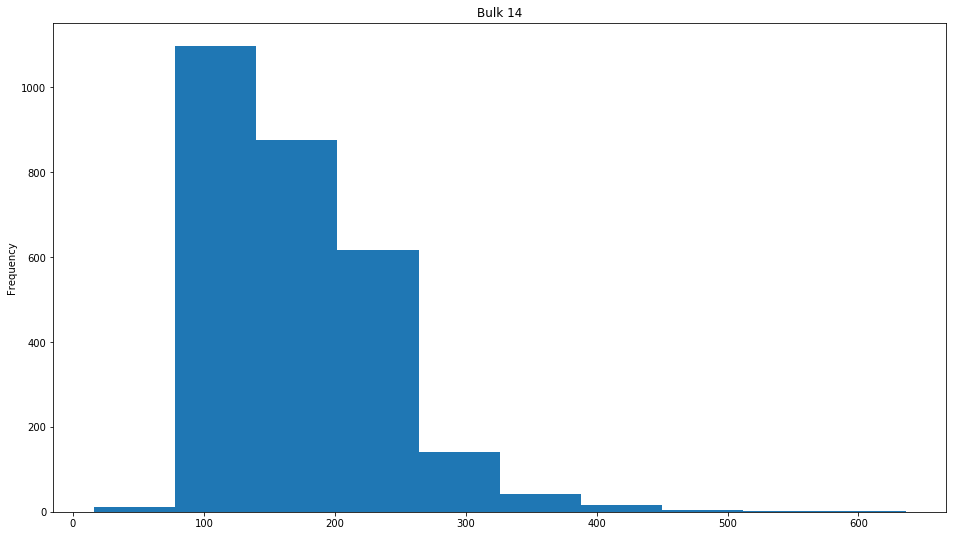

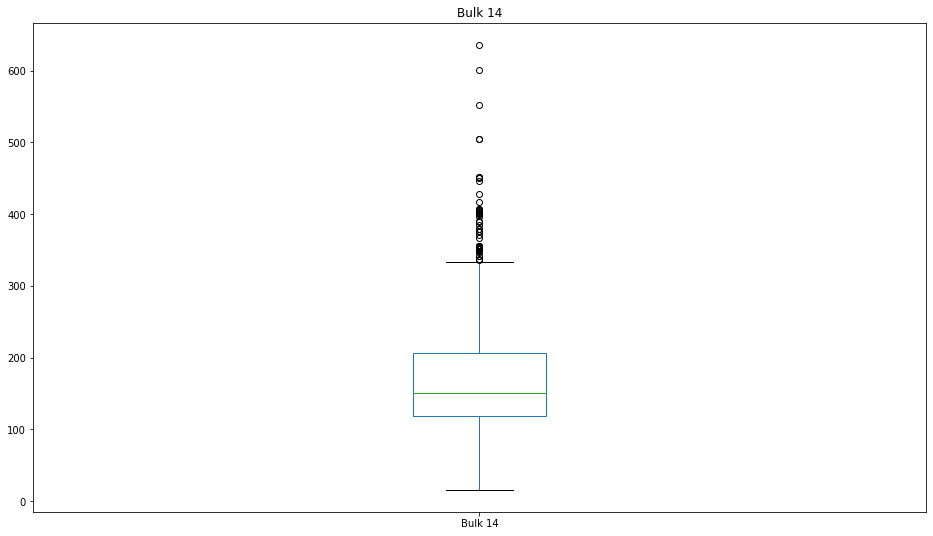

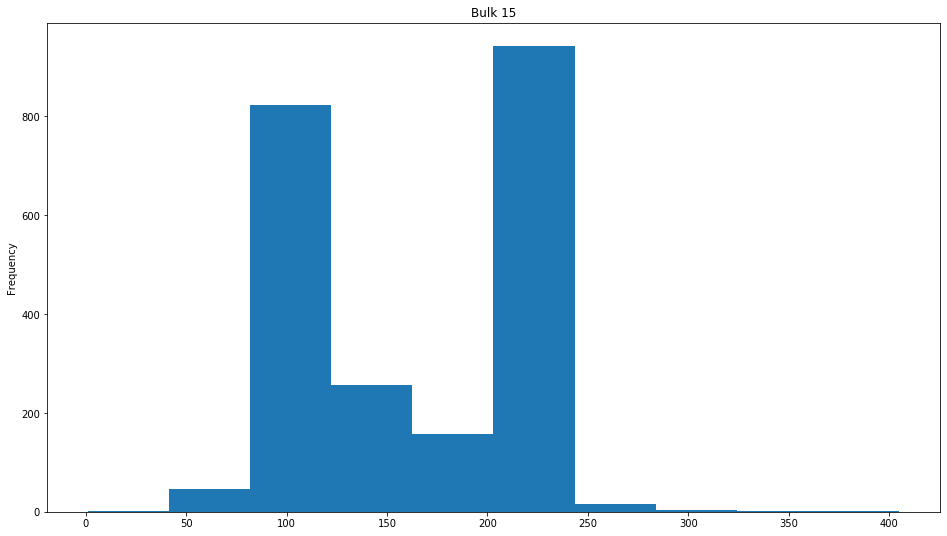

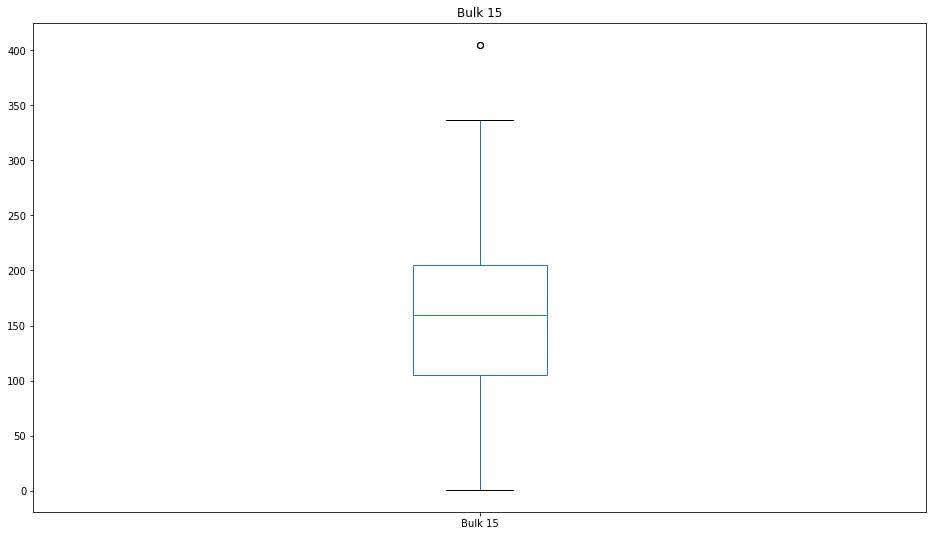

In [5]:
get_info(data_bulk)

**Выводы:** 
- Всего есть 15 видов примесей в виде кусков сплава
- Все переменные численные
- Много пропусков
- Нет дублей
- Есть выбросы
- Распределение порций примесей при добавлении неравномерное
- Количество партий меньше, чем в таблице про дугу. Значит не во все партии добавляли примеси
- Порядки величин для каждой примеси отличаются

**Что сделать**:
- Заменить пропуски на 0
- Удалить столбцы с большим количестом пропусков (к прмиеру, *bulk 8*) 
- Масштабировать значения
- Обработать выбросы

Информация о датасете data_bulk_time:
Общий вид датасета


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


Описание столбцов
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

Описание численных значений


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Количество пропусков, %
key         0.000000
Bulk 1     91.946309
Bulk 2     99.296900
Bulk 3     58.517098
Bulk 4     67.593480
Bulk 5     97.539150
Bulk 6     81.591563
Bulk 7     99.201023
Bulk 8     99.968041
Bulk 9     99.392777
Bulk 10    94.375200
Bulk 11    94.343241
Bulk 12    21.700224
Bulk 13    99.424736
Bulk 14    10.322787
Bulk 15    28.155960
dtype: float64
Количество дублей
0
Количество партий 3129


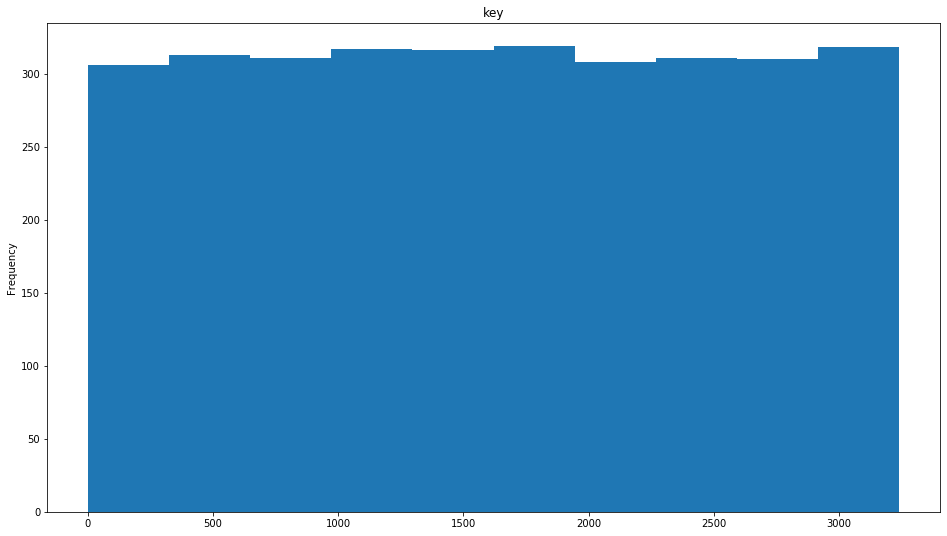

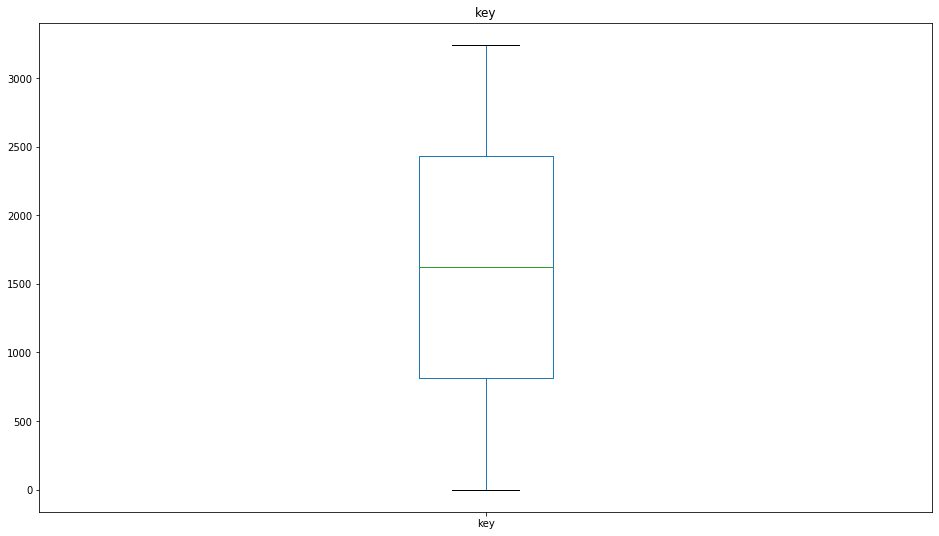

In [6]:
get_info(data_bulk_time)

**Выводы:** 
- Можно использовать время для отсеивания лишних замеров

**Что сделать**:
- Изменить тип данных на *datetime*

Информация о датасете data_gas:
Общий вид датасета


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Описание столбцов
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

Описание численных значений


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Количество пропусков, %
key      0.0
Газ 1    0.0
dtype: float64
Количество дублей
0
Количество партий 3239


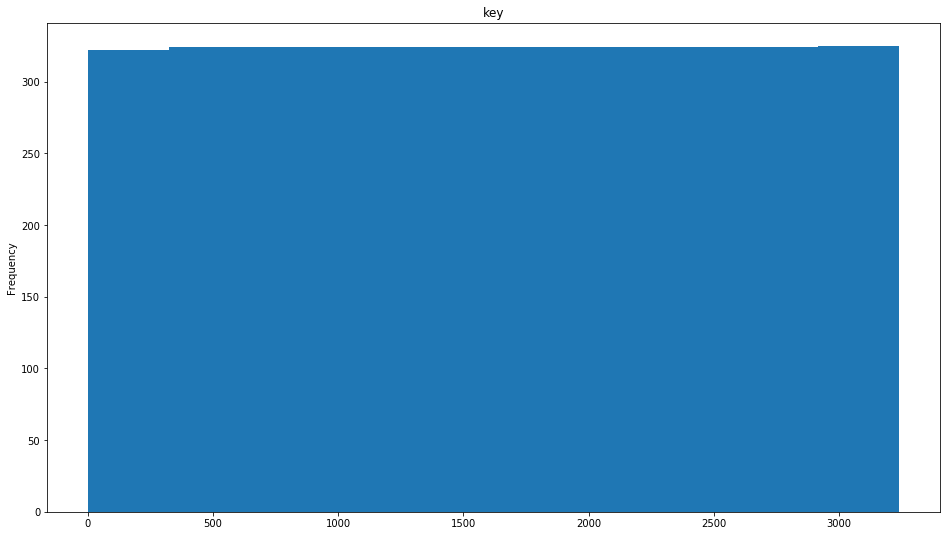

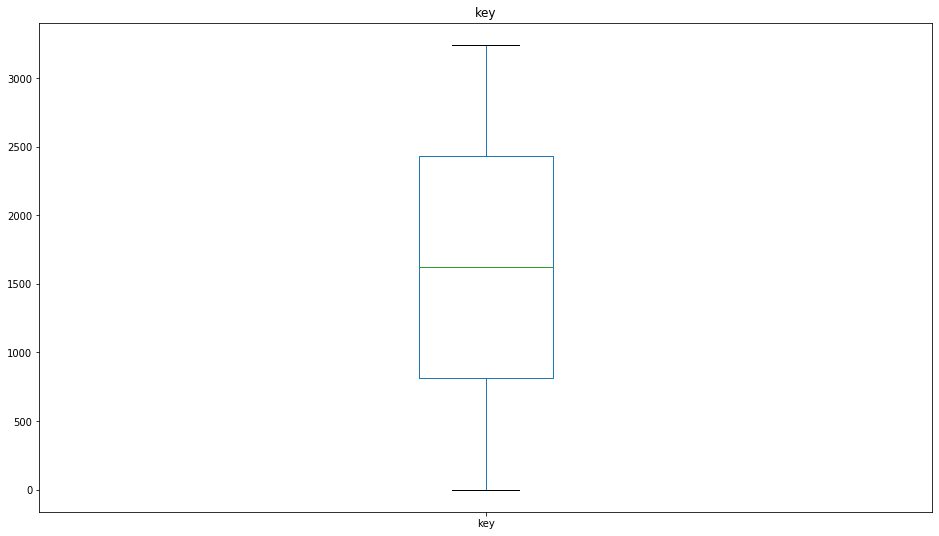

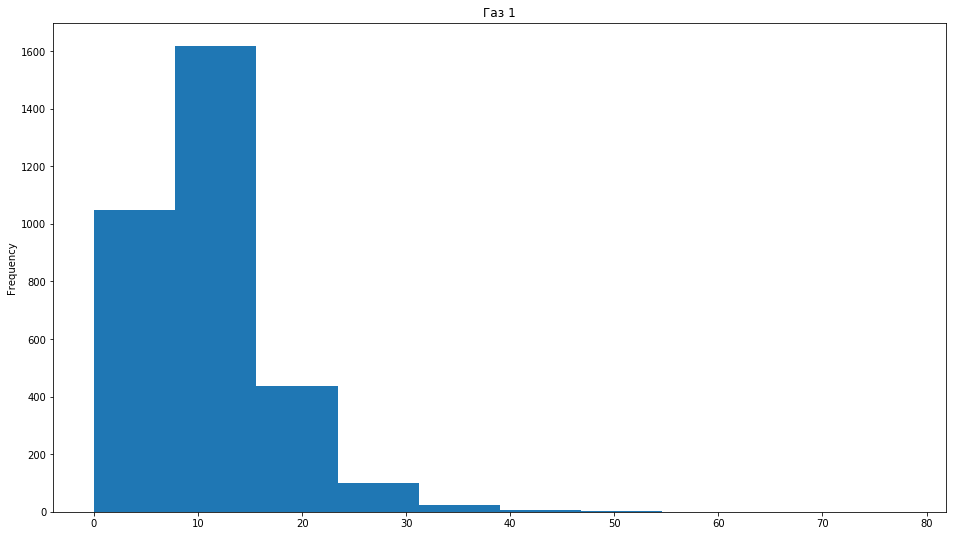

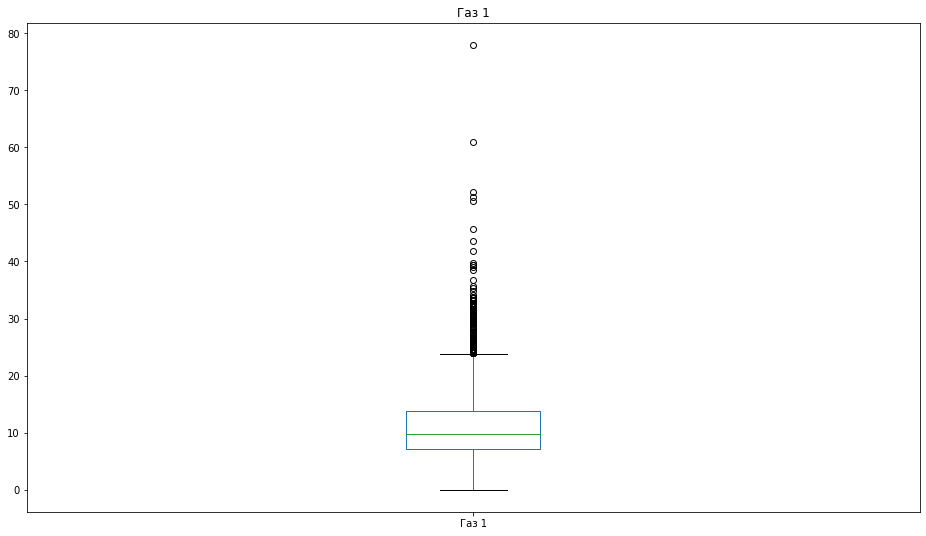

In [7]:
get_info(data_gas)

**Выводы:** 
- Количество партий больше (3239), чем в таблице про дугу (3214). Значит не все партии нагревали
- Есть выбросы
- Тяжелый правый хвост
- Нет пропусков и дублей

**Что сделать**:
- Обработать выбросы

Информация о датасете data_temp:
Общий вид датасета


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


Описание столбцов
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

Описание численных значений


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Количество пропусков, %
key              0.000000
Время замера     0.000000
Температура     18.237254
dtype: float64
Количество дублей
0
Количество партий 3216


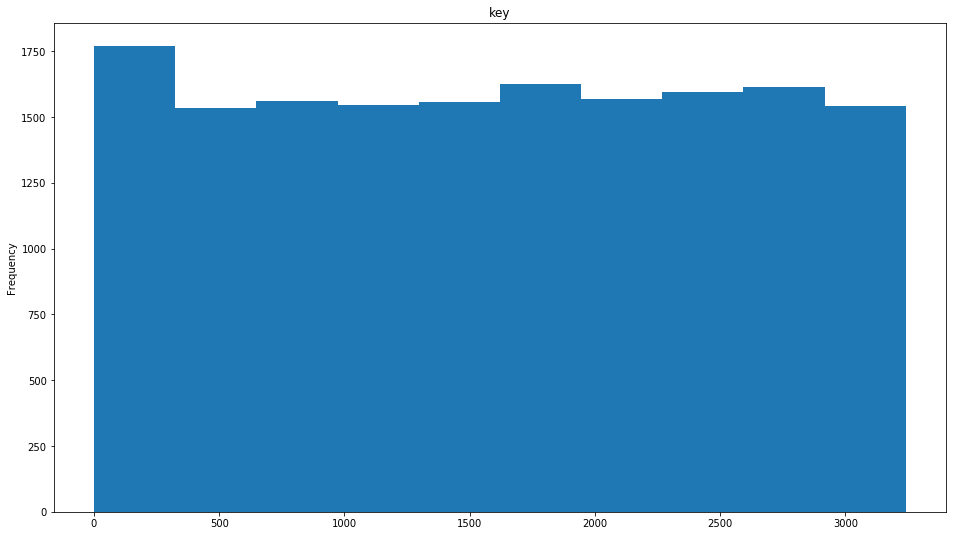

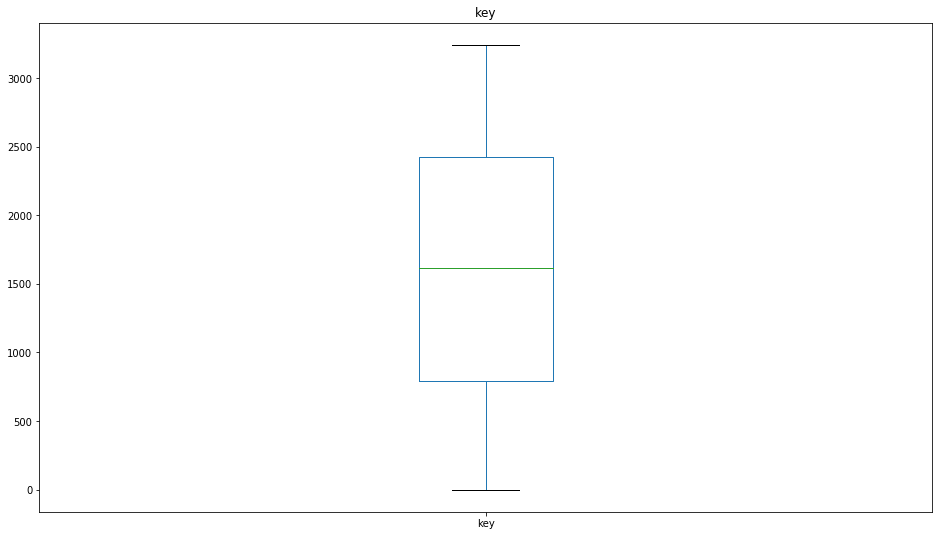

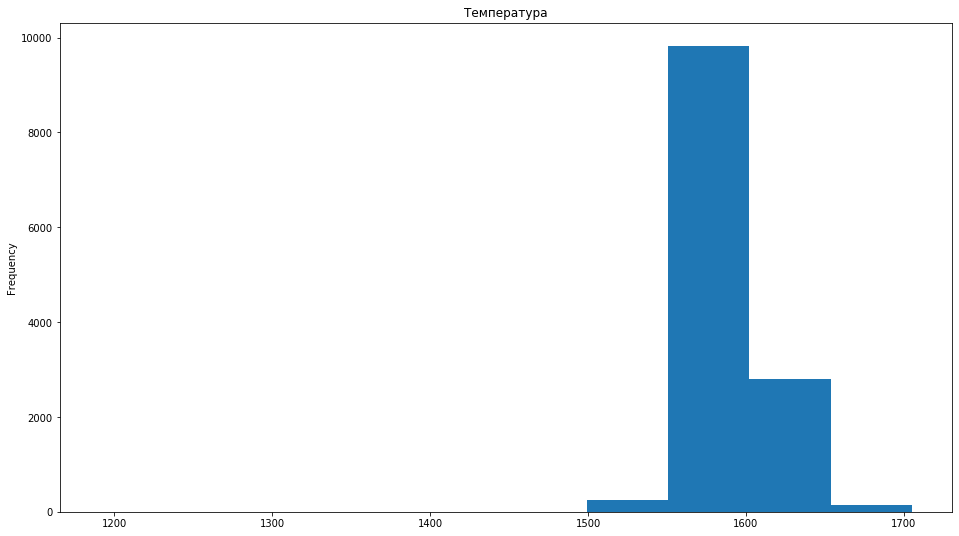

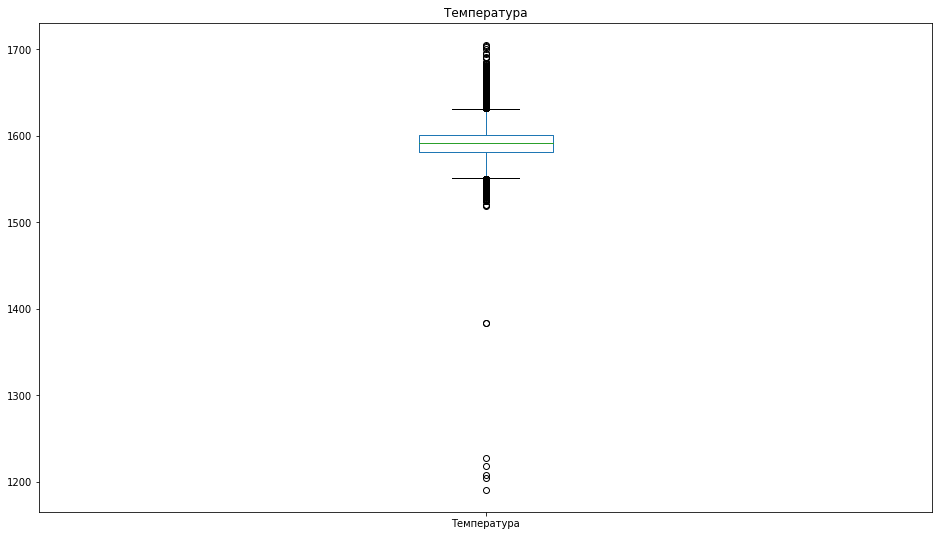

In [8]:
get_info(data_temp)

**Выводы:** 
- Есть пропуски по температуре
- Есть выбросы
- Распределение можно считать симметричным

**Что сделать**:
- Убрать из других таблиц записи полученные после последнего ненулевого значения температуры для каждой партии
- Обработать выбросы
- Выделить температуру последнего замера в целевой признак
- Выделить температуру первого замера в качестве признака для обучения

Информация о датасете data_wire:
Общий вид датасета


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Описание столбцов
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

Описание численных значений


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Количество пропусков, %
key        0.000000
Wire 1     0.843882
Wire 2    64.978903
Wire 3    97.955209
Wire 4    99.545602
Wire 5    99.967543
Wire 6    97.630639
Wire 7    99.642973
Wire 8    99.383317
Wire 9    99.058747
dtype: float64
Количество дублей
0
Количество партий 3081


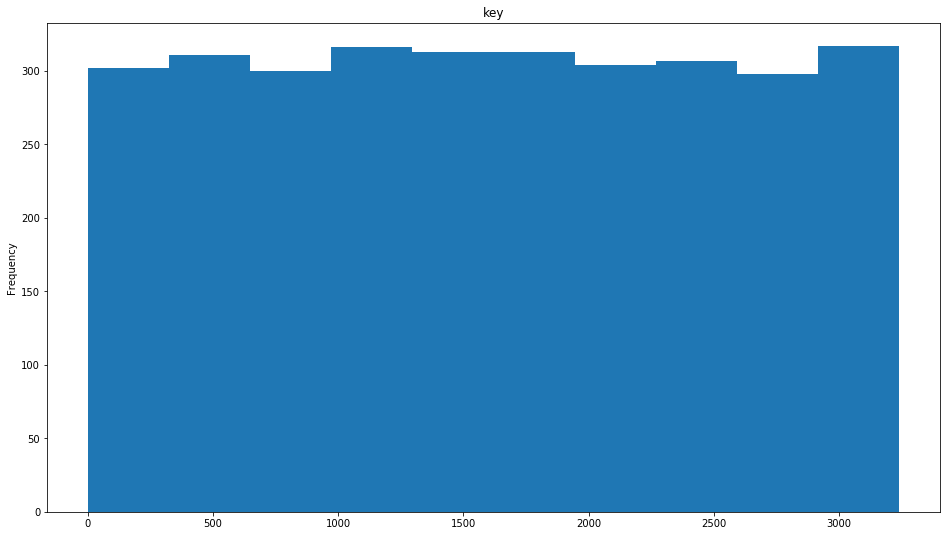

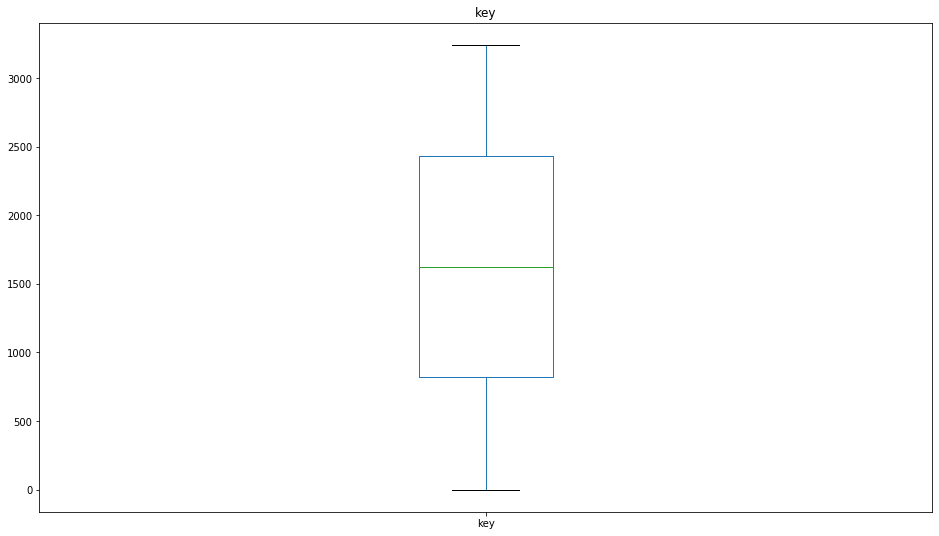

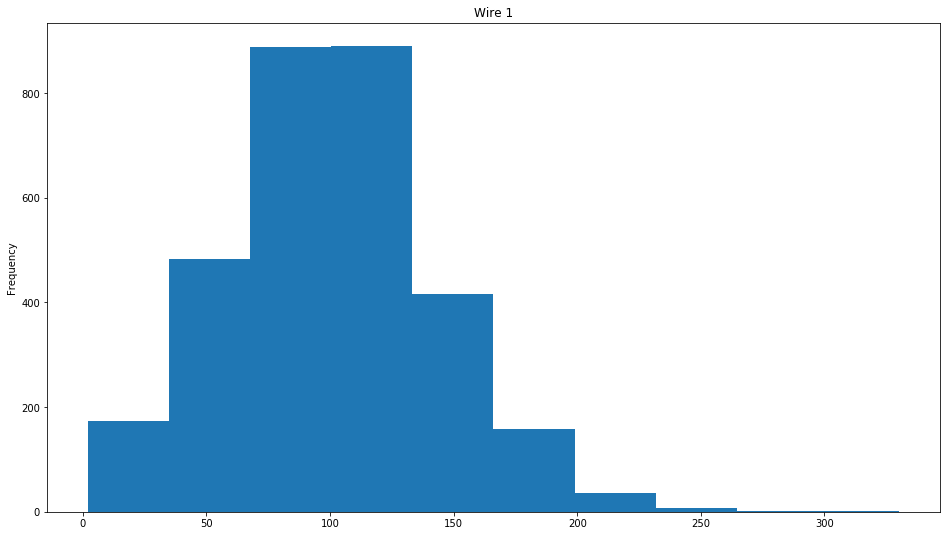

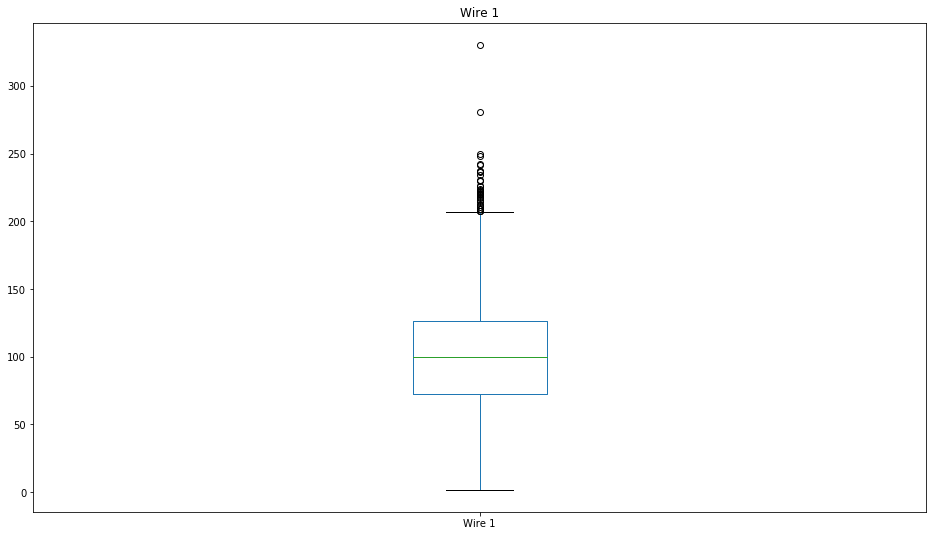

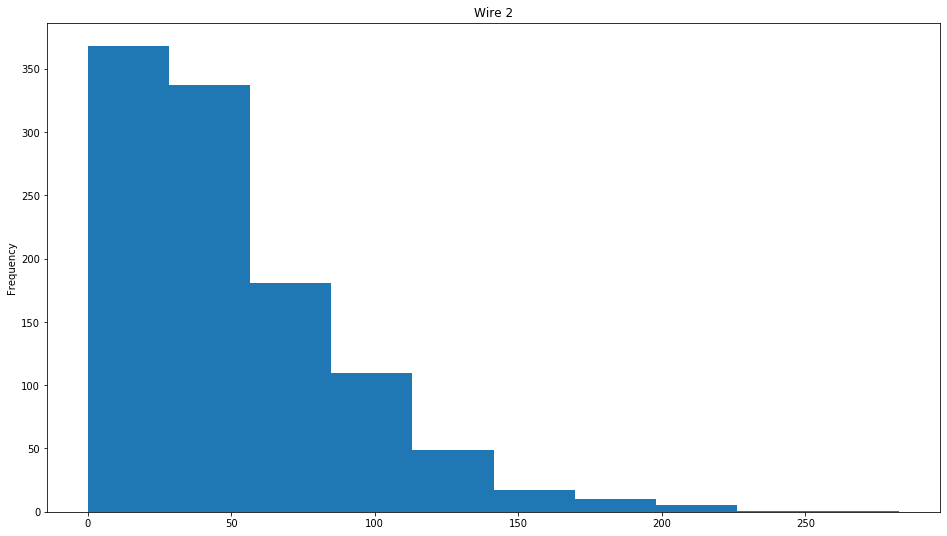

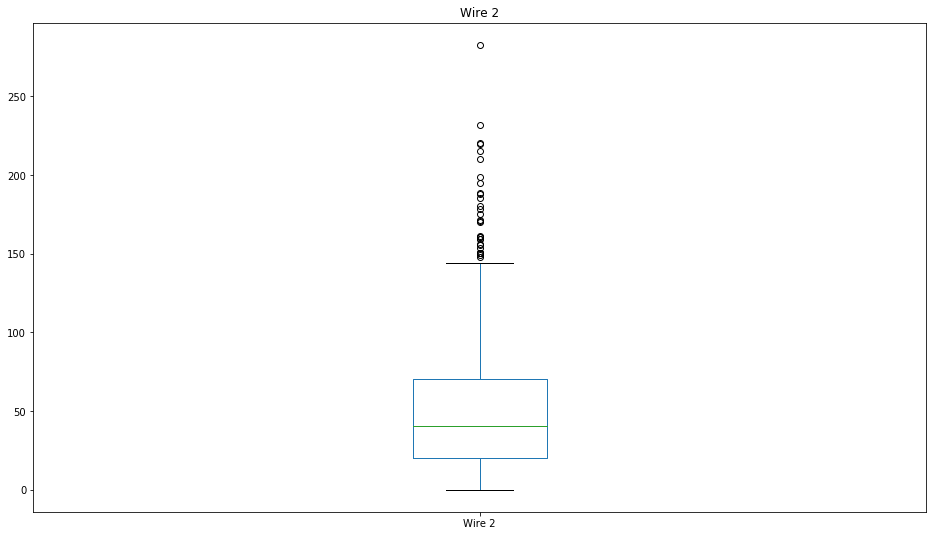

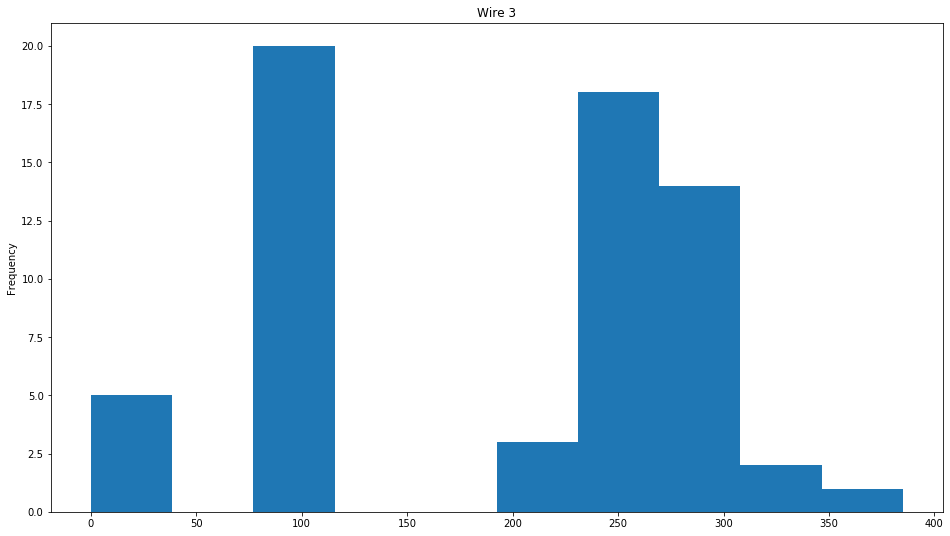

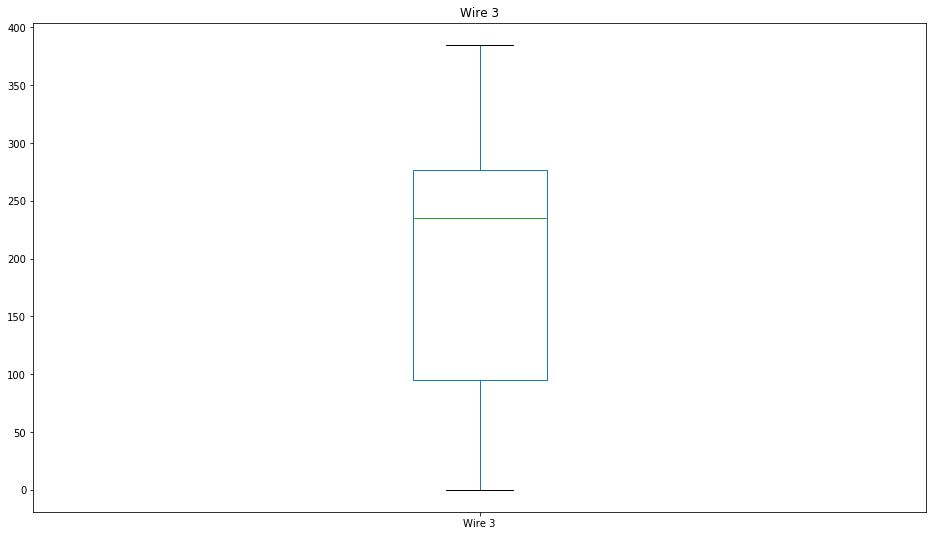

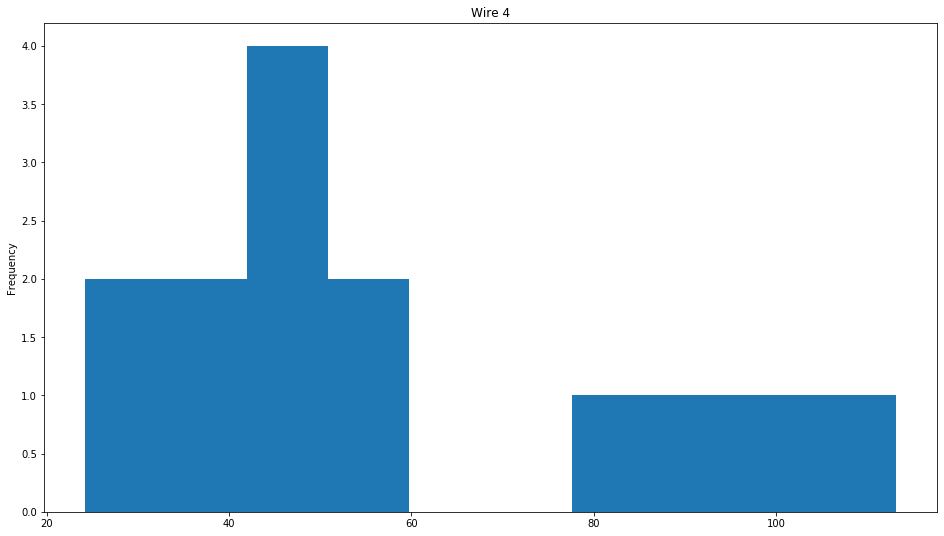

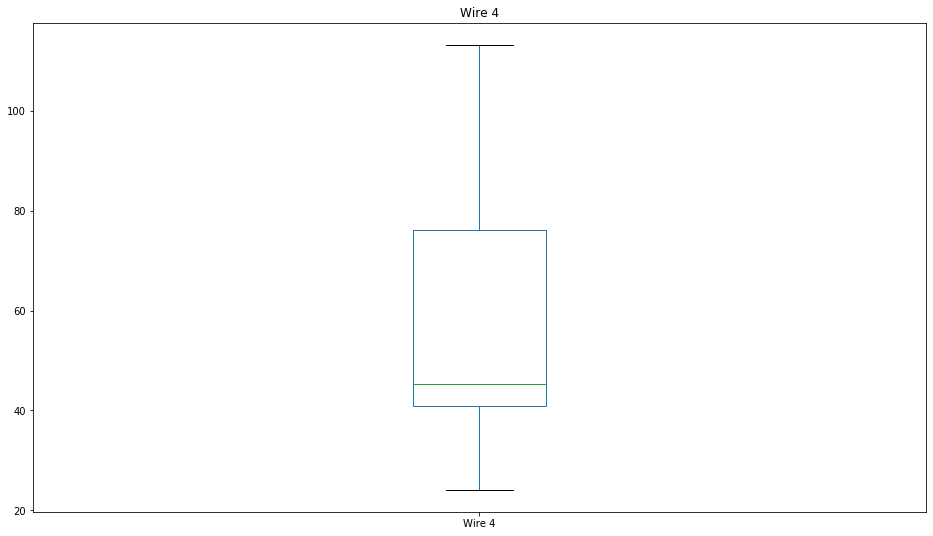

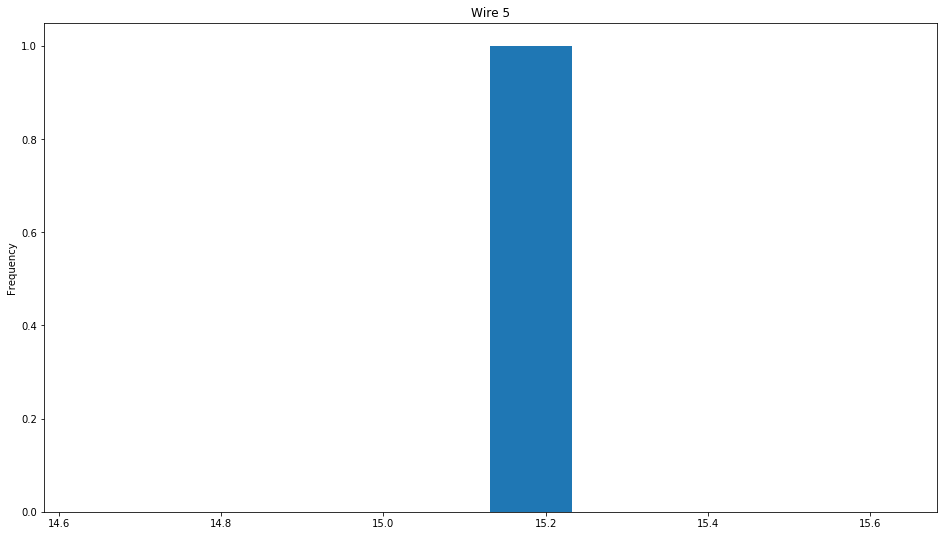

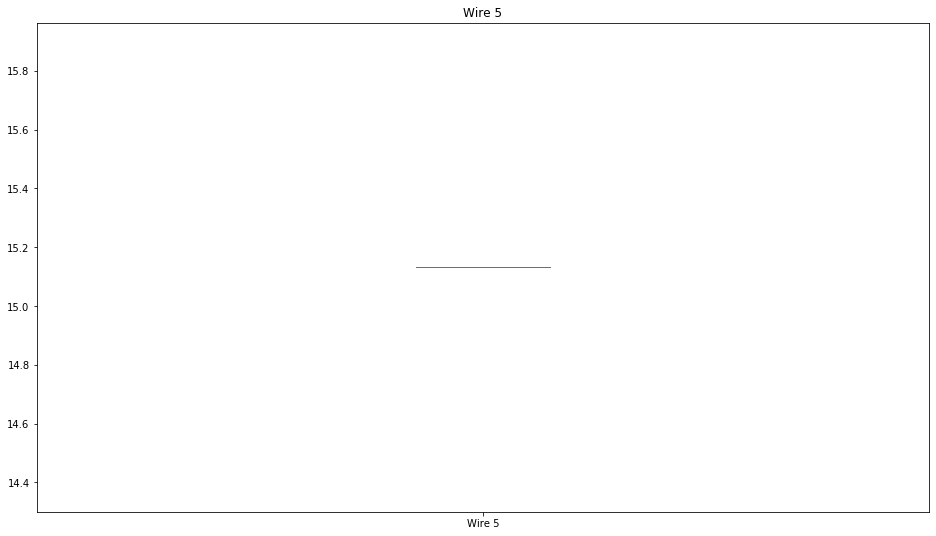

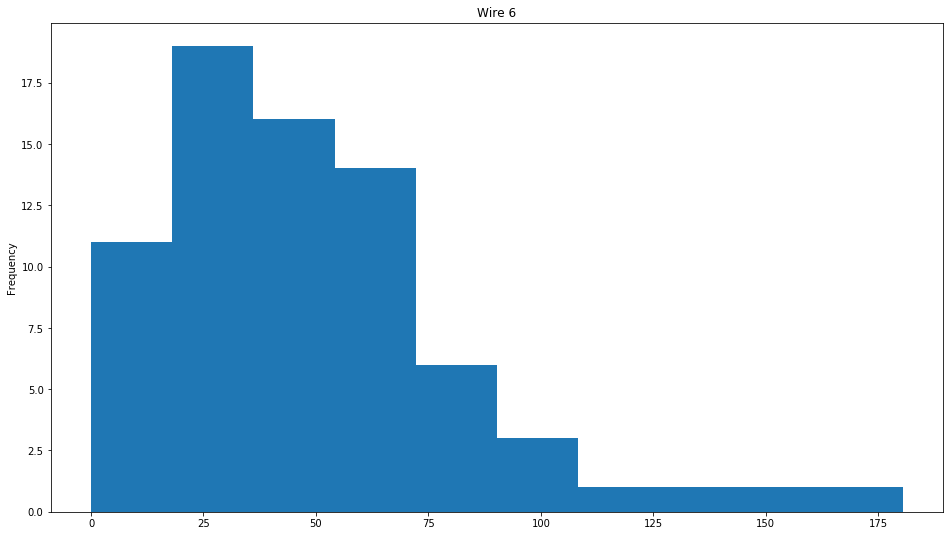

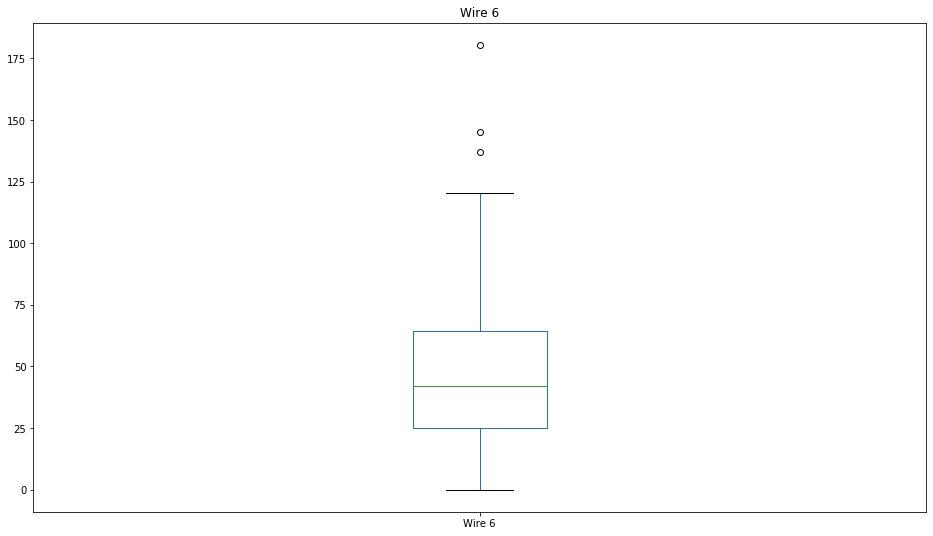

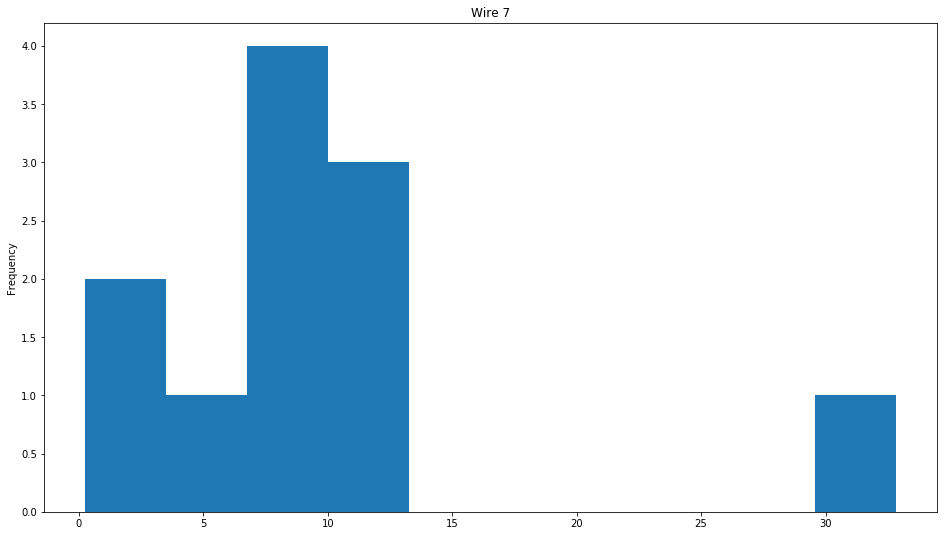

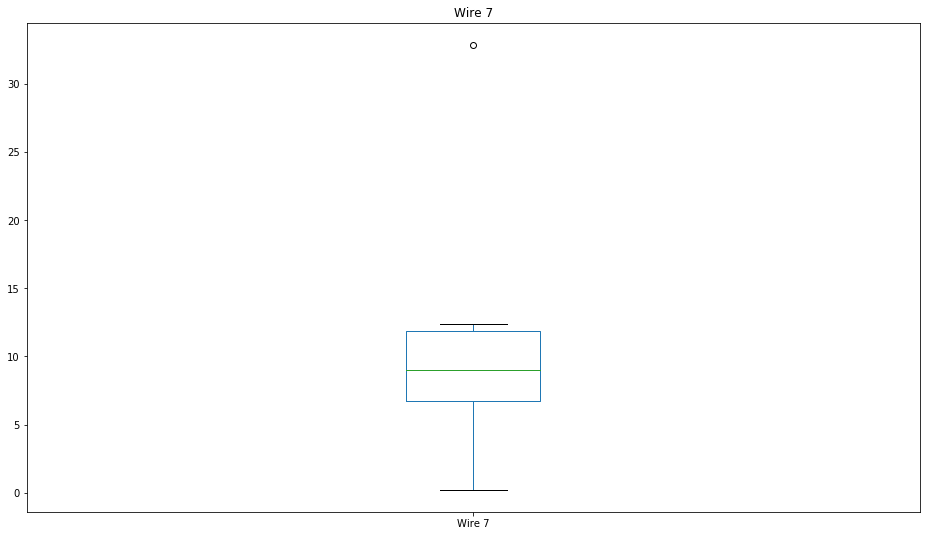

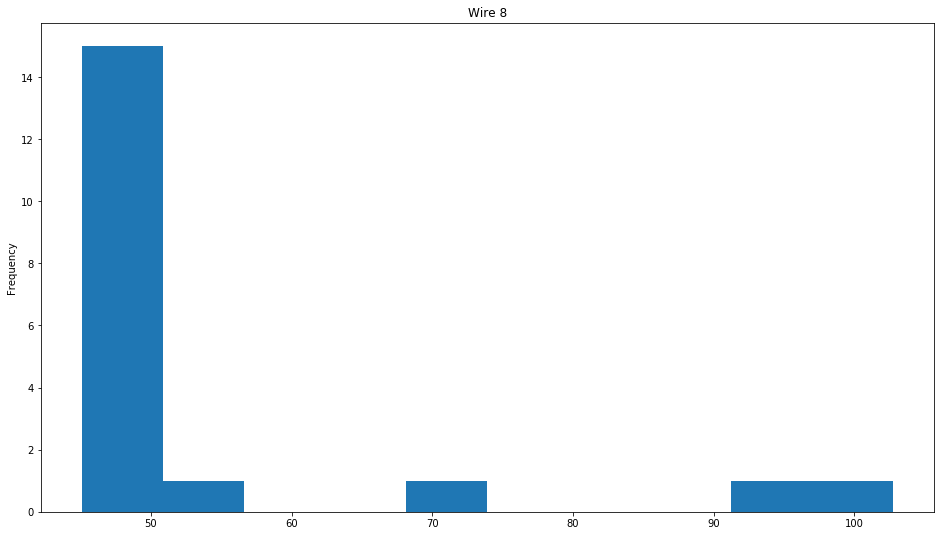

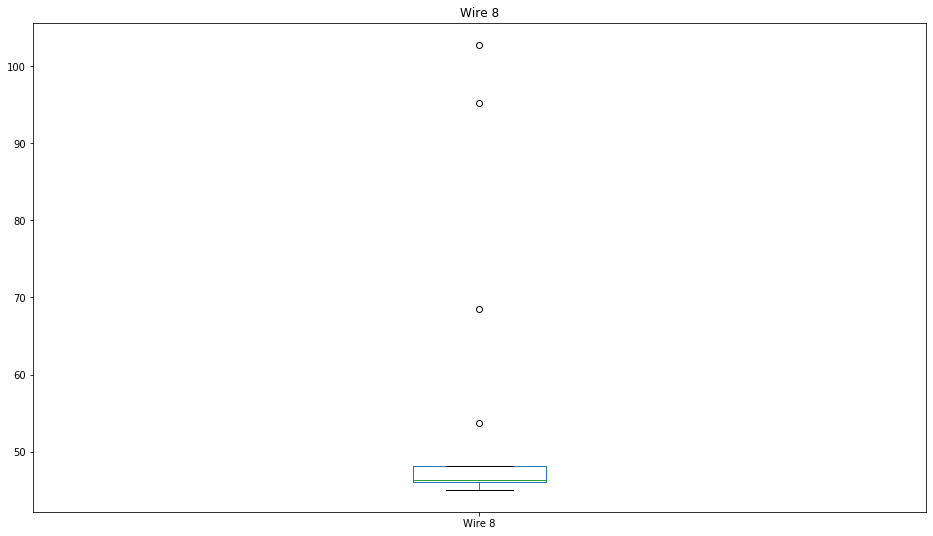

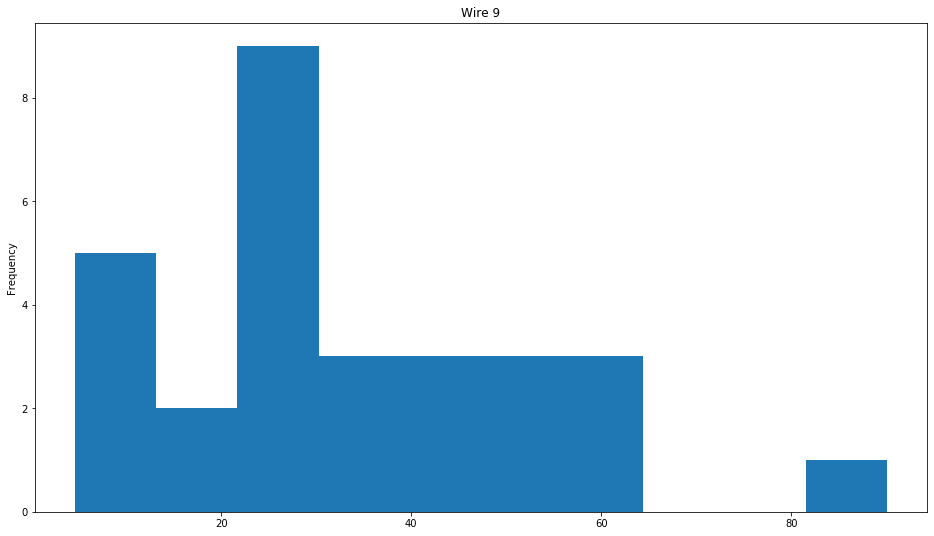

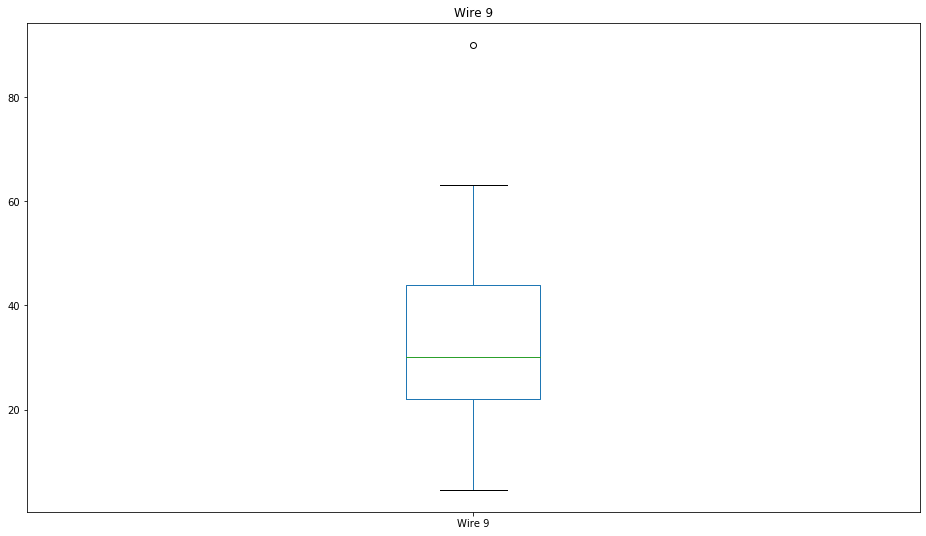

In [9]:
get_info(data_wire)

**Выводы:** 
- Всего есть 9 видов примесей в виде проволоки
- Все переменные численные
- Есть выбросы
- Много пропусков
- Нет дублей
- Распределение порций примесей при добавлении неравномерное
- Количество партий меньше, чем в таблице про дугу. Значит не во все партии добавляли примеси
- Для примесей величины отличаются на 2 порядка

**Что сделать**:
- Заменить пропуски 0
- Удалить столбцы с большим количестом пропусков (к прмиеру, *wire 5*) 
- Масштабировать значения
- Обработать выбросы

Информация о датасете data_wire_time:
Общий вид датасета


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Описание столбцов
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

Описание численных значений


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Количество пропусков, %
key        0.000000
Wire 1     0.843882
Wire 2    64.978903
Wire 3    97.955209
Wire 4    99.545602
Wire 5    99.967543
Wire 6    97.630639
Wire 7    99.642973
Wire 8    99.383317
Wire 9    99.058747
dtype: float64
Количество дублей
0
Количество партий 3081


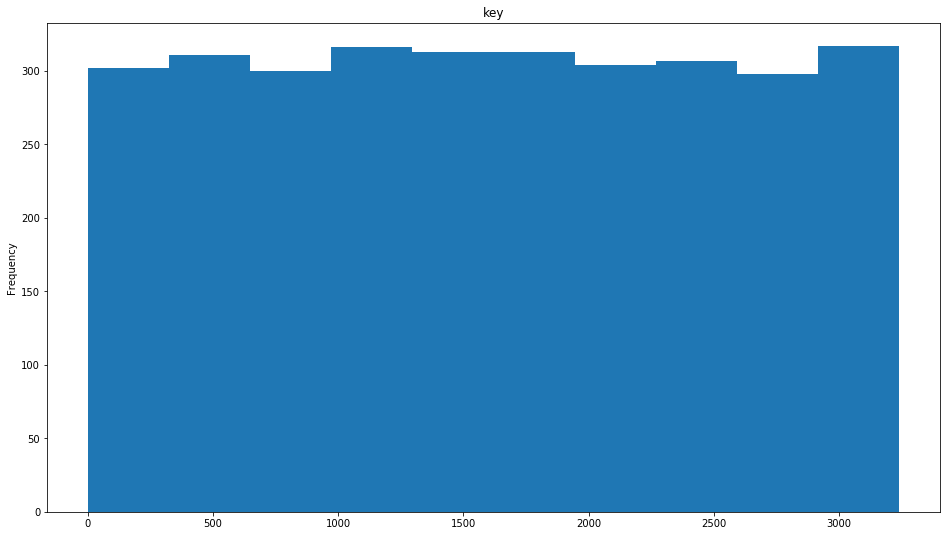

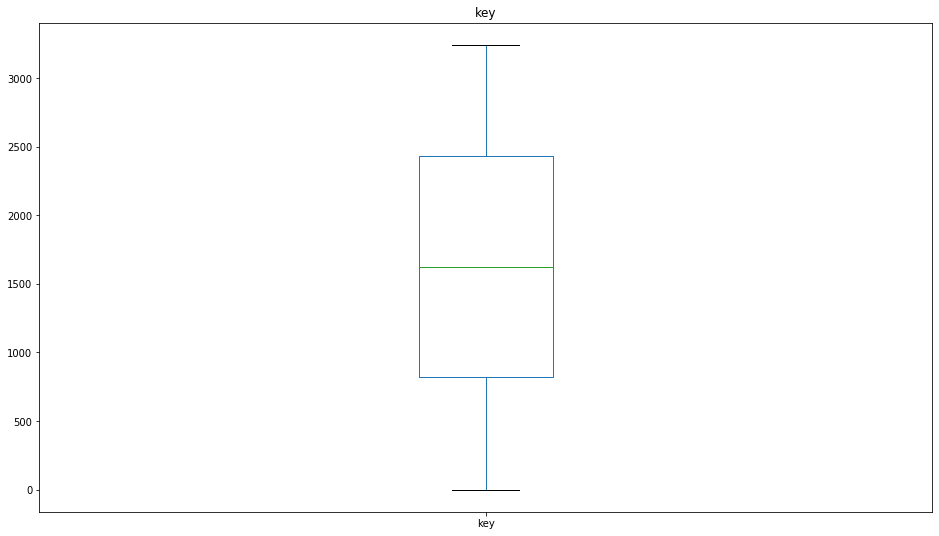

In [10]:
get_info(data_wire_time)

**Выводы:** 
- Можно использовать время для отсеивания лишних замеров

**Что сделать**:
- Изменить тип данных на *datetime*

## План решения задачи

1. **Предобработка данных.** Обработка пропусков, выбросов и лишних значений и признаков. Пропуски примесей заменить на 0. Неинформативные столбцы удалить, строки с выбросами можно удалить, но если в дальнейшей работе на вход будут подаваться данные с похожими распределениями, то удалять их не стоит. 
2. **Создание датасета с признаками и целевым признаком**. Целевым признаком является температура последнего замера для каждой партии. С помощью *merge* объединить целевой признак и другие признаки, убрав при этом записи, полученные после последнего замера температуры. Другие признаки (количество примесей, энергия) сгруппировать по партиям суммируя значения.
3. **Создание тренировочной и тестовой выборки**. Разбить выборку на тестовую и тренировочную и ,возможно, на валидационную. Провести масштабирование признаком по тренировочной выборке и обработать значения в других выборках
4. **Обучение разных моделей**. Обучить как простые модели (линейная регрессия и дерево решений), так и ансамбли моделей (случайный лес, градиентный бустинг). Если потребуется и будет время попробовать обучить нейросеть для выявления сложных зависимостей. Использовать оптимизацию гиперпараметров. Сравнить модели на адекватность с *dummy*-моделью, которая дает одно значение (среднее по выборке). 
5. **Сделать выводы**. Сделать выводы о проделланой работе, предложить что можно добавить/исправить.

## Предобработка данных

In [11]:
# Изменим тип данных на datetime, где требуется
datasets = [data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]
for data in datasets:
    for col in data.columns:
        if data[col].dtype == 'O':
            data[col] = pd.to_datetime(data[col], format='%Y-%m-%d %H:%M:%S')
    # Проверим тип данных
    print('='*50)
    data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null datetime64[ns]
Конец нагрева дугой     14876 non-null datetime64[ns]
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null

In [12]:
# Напишем функцию для удаления выбросов
def drop_distinct(df1):
    df = df1.copy()
    for col in df.columns:
        if col != 'key' and df[col].dtype == 'float64':
            q3 = np.nanpercentile(df[col], q=75)
            q1 =  np.nanpercentile(df[col], q=25)
            iqr = q3 - q1
            df = df.drop(df.loc[(df[col] > q3 + 1.5*iqr) | (df[col] < q1 - 1.5*iqr)].index)
    return df

Таблица *data_temp*

In [13]:
# Для каждой партии выделим первыую и последнюю температуры и время последнего замера
data_temp_processed = data_temp.copy()

# Удалим ненужные записи
data_temp_processed = drop_distinct(data_temp_processed)
data_temp_processed = data_temp_processed.dropna()
# Сгруппируем по партиям и найдем нужные значения температуры и времени
data_temp_processed = data_temp_processed.groupby('key').agg(
    {'Температура':['first', 'last'], 'Время замера':['first','last']}).reset_index() 
# Избавимся от многоуровневых названий столбцов и переименуем их
data_temp_processed.columns = data_temp_processed.columns.droplevel(0)
data_temp_processed.columns = ['key','Начальная температура','Конечная температура',
                               'Время первого замера','Время последнего замера']
# Уберем строки в которых был только один замер
data_temp_processed = data_temp_processed.loc[
    data_temp_processed['Время первого замера'] != data_temp_processed['Время последнего замера']]
# Првоерим результат
data_temp_processed

,key,Начальная температура,Конечная температура,Время первого замера,Время последнего замера
0,1,1571.0,1613.0,2019-05-03 11:16:18,2019-05-03 11:30:39
1,2,1581.0,1602.0,2019-05-03 11:37:27,2019-05-03 11:59:12
2,3,1596.0,1599.0,2019-05-03 12:13:17,2019-05-03 12:34:57
3,4,1601.0,1625.0,2019-05-03 12:52:57,2019-05-03 12:59:25
4,5,1576.0,1602.0,2019-05-03 13:23:19,2019-05-03 13:36:01
...,...,...,...,...,...
2431,2495,1570.0,1591.0,2019-08-06 00:35:45,2019-08-06 00:54:42
2432,2496,1554.0,1591.0,2019-08-06 01:02:54,2019-08-06 01:29:52
2433,2497,1571.0,1589.0,2019-08-06 01:41:53,2019-08-06 01:53:50
2434,2498,1591.0,1594.0,2019-08-06 02:03:49,2019-08-06 02:25:31


Таблица *data_arc*

In [14]:
# Напишем функцию, которая определяет какие записи(итерации) 
# были получены до последнего замера температуры в каждой партии
def choose_by_time(row):
    key = row['key']
    time = data_temp_processed.loc[data_temp_processed['key'] == key]['Время последнего замера'].values
    return row['Конец нагрева дугой'] <= pd.to_datetime(time, format='%Y-%m-%d %H:%M:%S')

In [15]:
data_arc_processed = data_arc.copy()

# Уберем отрицательные значения мощности
data_arc_processed = data_arc_processed.loc[(data_arc_processed['Активная мощность'] > 0) &
                                           (data_arc_processed['Реактивная мощность'] > 0)]
# Добавим столбец, который покажет какие строки были получены до последнего замера температуры 
# и выделим нужные
data_arc_processed['Использовать'] = data_arc.apply(choose_by_time, axis=1)
data_arc_processed = data_arc_processed.loc[data_arc_processed['Использовать'] == True]\
                                        .drop(columns=['Использовать'])

# Добавим длительность нагрева в новый столбец
data_arc_processed['Длительность нагрева'] = (
    data_arc_processed['Конец нагрева дугой'] - data_arc_processed['Начало нагрева дугой']).dt.total_seconds()
# Найдем полную мощность
data_arc_processed['Полная мощность'] = (data_arc_processed['Активная мощность']**2 
                               + data_arc_processed['Реактивная мощность']**2)**(1/2)
# Найдем энергию активной и полной мощности
data_arc_processed['Энергия'] = data_arc_processed['Длительность нагрева'] \
                                * data_arc_processed['Активная мощность']
data_arc_processed['Полная энергия'] = data_arc_processed['Длительность нагрева'] \
                                        * data_arc_processed['Полная мощность']

# Сгруппируем данные по партиям и сложим значения энергий
data_arc_processed = data_arc_processed.groupby('key').sum()[['Энергия', 'Полная энергия']]\
                                        .reset_index()
# Удалим выбросы
data_arc_processed = drop_distinct(data_arc_processed)

# Проверим что получилось
data_arc_processed

,key,Энергия,Полная энергия
0,1,1207.804249,1442.377754
1,2,733.816470,881.233565
2,3,443.583327,525.066777
3,4,670.663327,796.911309
4,5,997.496095,1199.137958
...,...,...,...
2400,2495,626.167357,778.818234
2401,2496,727.868032,875.261419
2402,2497,427.535518,556.930349
2403,2498,629.928649,767.817794


**Таблицы *data_bulk* и *data_bulk_time***

In [16]:
# Напишем функцию, которая выберет только записи с добавлением примесей, 
# сделанные до последнего замера температуры
def get_right_notes(data, data_time):
    data_processed = data.copy()
    data_time_processed = data_time.copy()
    # Удалим выбросы
    data_processed = drop_distinct(data_processed)

    # Выберем те записи, которые есть и в целевой переменной тоже
    data_time_processed = data_time_processed.merge(
            data_temp_processed[['key', 'Время последнего замера']], on='key', how='inner')
    data_processed = data_processed.merge(
            data_temp_processed[['key']], on='key', how='inner')
    # Датасет mask для переноса толкьо нужных значений, ненужные заполняться как NaN
    mask = pd.DataFrame()
    mask['key'] = data_processed['key']
    for col in data_processed.columns:
        if col == 'key' or col == 'Время последнего замера':
            continue
        # Выберем те записи, которые были до последнего замера температуры
        # Второе условия, чтобы исключить сравнение даты с NaT
        take_it = (data_time_processed[col] < data_time_processed['Время последнего замера']) \
                    & data_time_processed[col].notnull() 
        mask[col] = data_processed[col].loc[take_it]
        
    # Удалим признаки, которые имеют по выборке пропусков больше, чем 75й персентиль по всем столбцам
    cols = mask.columns[mask.isnull().mean() > 
                                  np.percentile(mask.isnull().mean(), q=75)]
    mask = mask.drop(columns=cols)

    # Заполним пропуски
    mask = mask.fillna(0)
    return mask

In [17]:
data_bulk_processed = get_right_notes(data_bulk, data_bulk_time)
data_bulk_processed

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,206.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,206.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,205.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,207.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,203.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2153,2495,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,256.0,0.0,223.0
2154,2496,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,256.0,129.0,226.0
2155,2497,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,230.0,124.0,0.0
2156,2498,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,206.0,129.0,207.0


**Таблица *data_gas***

In [18]:
data_gas_processed = data_gas.copy()
# Уберем пропуски
data_gas_processed = drop_distinct(data_gas_processed)
data_gas_processed

,key,Газ 1
1,2,12.555561
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


**Таблица *data_wire* и *data_wire_time***

In [19]:
data_wire_processed = get_right_notes(data_wire, data_wire_time)
data_wire_processed 

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 8
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2297,2495,89.150879,0.00000,0.0,0.0,0.0,0.0
2298,2496,114.179527,0.00000,0.0,0.0,0.0,0.0
2299,2497,94.086723,9.04800,0.0,0.0,0.0,0.0
2300,2498,118.110717,0.00000,0.0,0.0,0.0,0.0


## Создание датасета с признаками и целевым признаком

In [20]:
# Объединим все таблицы в одну
final_df = data_temp_processed[['key', 'Начальная температура', 'Конечная температура']]\
                                .merge(data_arc_processed, on='key', how='inner')\
                                .merge(data_gas_processed,on='key', how='inner')\
                                .merge(data_bulk_processed,on='key', how='inner')\
                                .merge(data_wire_processed, on='key', how='inner')

final_df

,key,Начальная температура,Конечная температура,Энергия,Полная энергия,Газ 1,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 8
0,2,1581.0,1602.0,733.816470,881.233565,12.555561,0.0,0.0,0.0,73.0,...,0.0,206.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0
1,4,1601.0,1625.0,670.663327,796.911309,18.841219,0.0,0.0,0.0,81.0,...,0.0,207.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0
2,5,1576.0,1602.0,997.496095,1199.137958,5.413692,0.0,0.0,0.0,78.0,...,0.0,203.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0
3,6,1581.0,1596.0,1157.263817,1410.747219,11.273392,0.0,0.0,0.0,117.0,...,0.0,204.0,201.0,154.0,99.109917,9.11456,0.0,0.0,0.0,0.0
4,7,1586.0,1599.0,622.474471,729.780631,9.836267,0.0,0.0,0.0,117.0,...,0.0,204.0,152.0,154.0,98.061600,0.00000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924,2495,1570.0,1591.0,626.167357,778.818234,7.125735,0.0,0.0,21.0,0.0,...,0.0,256.0,0.0,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0
1925,2496,1554.0,1591.0,727.868032,875.261419,9.412616,0.0,0.0,0.0,63.0,...,0.0,256.0,129.0,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0
1926,2497,1571.0,1589.0,427.535518,556.930349,6.271699,0.0,0.0,0.0,85.0,...,0.0,230.0,124.0,0.0,94.086723,9.04800,0.0,0.0,0.0,0.0
1927,2498,1591.0,1594.0,629.928649,767.817794,14.953657,0.0,0.0,90.0,0.0,...,0.0,206.0,129.0,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0


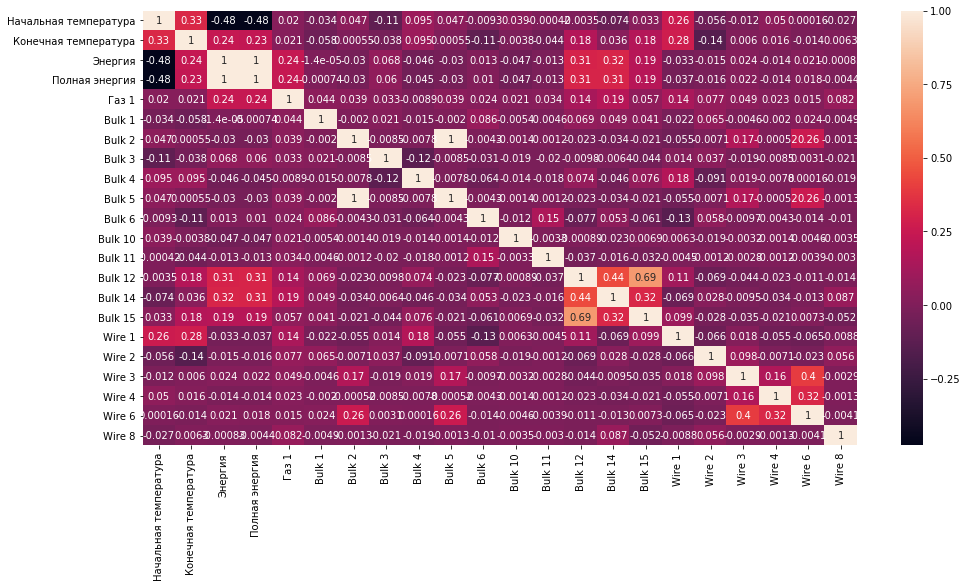

In [21]:
# Посмотрим на корреляцию признаков
plt.figure(figsize=(16,8))
sns.heatmap(data=final_df.drop(columns=['key']).corr(), annot=True,)

Столбцы "Энергия" и "Полная энергия" ,очевидно, имеют сильную корреляцию. В качестве признака оставим обычную энергию, так как именно она идет на нагрев металла. Есть также признаки с отрицательной корреляцией.  Возможно, именно эти примеси определяют теплоемкость сплава. Высокая корерляция наблюдается между *Bulk 12*, *Bulk 14* и *Bulk 15*. Похожая ситуация с примесями *Wire 3*, *Wire 4* и *Wire 6*.
Предварительно на целевйо признак оказывают больше влияние начальная температура, энергия и примесь *Wire 1*.

In [22]:
# Создадим тренировочную и тестовую выборки
features = final_df.drop(columns=['key','Конечная температура', 'Полная энергия', 'Bulk 5'])
target = final_df['Конечная температура']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, random_state=12345, test_size=0.25)

In [23]:
# Отмасштабируем признаки
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

## Обучение моделей

In [24]:
# Подберем параметры для дерева решений
DTR = DecisionTreeRegressor(random_state=12345)
params = {'max_depth':list(range(1,100,5))}
DTR_grid = GridSearchCV(DTR, params, scoring='neg_mean_absolute_error', cv=3)
DTR_grid.fit(features_train, target_train)
DTR_grid.best_params_

{'max_depth': 6}

In [25]:
# Подберем параметры для случайного леса
RFR = RandomForestRegressor(random_state=12345)
params = {'max_depth':list(range(1,300,10)), 
         'n_estimators': list(range(1,100,20))}
RFR_grid = GridSearchCV(RFR, params, scoring='neg_mean_absolute_error', cv=3, verbose=144)
RFR_grid.fit(features_train, target_train)
RFR_grid.best_params_

Fitting 3 folds for each of 150 candidates, totalling 450 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_depth=1, n_estimators=1 .....................................
[CV] ........ max_depth=1, n_estimators=1, score=-7.741, total=   0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, n_estimators=1 .....................................
[CV] ........ max_depth=1, n_estimators=1, score=-6.890, total=   0.1s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, n_estimators=1 .....................................
[CV] ........ max_depth=1, n_estimators=1, score=-7.525, total=   0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, n_estimators=21 ....................................
[CV] ....... max_depth=1, n_estimators=21, score=-7.479, total=   0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elap

{'max_depth': 11, 'n_estimators': 61}

In [26]:
# Подберем параметры для случайного леса
LGBM = LGBMRegressor(random_state=12345)
params = {'max_depth':list(range(1,100,10)), 
         'n_estimators': list(range(1,400,20))}
LGBM_grid = GridSearchCV(LGBM, params, scoring='neg_mean_absolute_error', cv=3, verbose=48)
LGBM_grid.fit(features_train, target_train)
LGBM_grid.best_params_

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[CV] max_depth=1, n_estimators=1 .....................................
[CV] ........ max_depth=1, n_estimators=1, score=-7.724, total=   0.0s
[CV] max_depth=1, n_estimators=1 .....................................
[CV] ........ max_depth=1, n_estimators=1, score=-6.953, total=   0.1s
[CV] max_depth=1, n_estimators=1 .....................................
[CV] ........ max_depth=1, n_estimators=1, score=-7.192, total=   0.0s
[CV] max_depth=1, n_estimators=21 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s


[CV] ....... max_depth=1, n_estimators=21, score=-7.205, total=   0.1s
[CV] max_depth=1, n_estimators=21 ....................................
[CV] ....... max_depth=1, n_estimators=21, score=-6.348, total=   0.1s
[CV] max_depth=1, n_estimators=21 ....................................
[CV] ....... max_depth=1, n_estimators=21, score=-6.716, total=   0.0s
[CV] max_depth=1, n_estimators=41 ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.3s remaining:    0.0s


[CV] ....... max_depth=1, n_estimators=41, score=-6.937, total=   0.1s
[CV] max_depth=1, n_estimators=41 ....................................
[CV] ....... max_depth=1, n_estimators=41, score=-6.146, total=   0.1s
[CV] max_depth=1, n_estimators=41 ....................................
[CV] ....... max_depth=1, n_estimators=41, score=-6.495, total=   0.1s
[CV] max_depth=1, n_estimators=61 ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s


[CV] ....... max_depth=1, n_estimators=61, score=-6.820, total=   0.1s
[CV] max_depth=1, n_estimators=61 ....................................
[CV] ....... max_depth=1, n_estimators=61, score=-6.122, total=   0.1s
[CV] max_depth=1, n_estimators=61 ....................................
[CV] ....... max_depth=1, n_estimators=61, score=-6.410, total=   0.1s
[CV] max_depth=1, n_estimators=81 ....................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.9s remaining:    0.0s


[CV] ....... max_depth=1, n_estimators=81, score=-6.752, total=   0.1s
[CV] max_depth=1, n_estimators=81 ....................................
[CV] ....... max_depth=1, n_estimators=81, score=-6.073, total=   0.1s
[CV] max_depth=1, n_estimators=81 ....................................
[CV] ....... max_depth=1, n_estimators=81, score=-6.363, total=   0.1s
[CV] max_depth=1, n_estimators=101 ...................................


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.2s remaining:    0.0s


[CV] ...... max_depth=1, n_estimators=101, score=-6.713, total=   0.2s
[CV] max_depth=1, n_estimators=101 ...................................
[CV] ...... max_depth=1, n_estimators=101, score=-6.081, total=   0.1s
[CV] max_depth=1, n_estimators=101 ...................................


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    1.5s remaining:    0.0s


[CV] ...... max_depth=1, n_estimators=101, score=-6.341, total=   0.2s
[CV] max_depth=1, n_estimators=121 ...................................
[CV] ...... max_depth=1, n_estimators=121, score=-6.697, total=   0.2s
[CV] max_depth=1, n_estimators=121 ...................................


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.9s remaining:    0.0s


[CV] ...... max_depth=1, n_estimators=121, score=-6.070, total=   0.1s
[CV] max_depth=1, n_estimators=121 ...................................
[CV] ...... max_depth=1, n_estimators=121, score=-6.332, total=   0.2s
[CV] max_depth=1, n_estimators=141 ...................................


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    2.2s remaining:    0.0s


[CV] ...... max_depth=1, n_estimators=141, score=-6.674, total=   0.2s
[CV] max_depth=1, n_estimators=141 ...................................
[CV] ...... max_depth=1, n_estimators=141, score=-6.047, total=   0.1s
[CV] max_depth=1, n_estimators=141 ...................................


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    2.5s remaining:    0.0s


[CV] ...... max_depth=1, n_estimators=141, score=-6.326, total=   0.2s
[CV] max_depth=1, n_estimators=161 ...................................
[CV] ...... max_depth=1, n_estimators=161, score=-6.661, total=   0.2s
[CV] max_depth=1, n_estimators=161 ...................................


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    2.9s remaining:    0.0s


[CV] ...... max_depth=1, n_estimators=161, score=-6.050, total=   0.2s
[CV] max_depth=1, n_estimators=161 ...................................
[CV] ...... max_depth=1, n_estimators=161, score=-6.308, total=   0.2s
[CV] max_depth=1, n_estimators=181 ...................................


[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    3.3s remaining:    0.0s


[CV] ...... max_depth=1, n_estimators=181, score=-6.652, total=   0.3s
[CV] max_depth=1, n_estimators=181 ...................................
[CV] ...... max_depth=1, n_estimators=181, score=-6.045, total=   0.1s
[CV] max_depth=1, n_estimators=181 ...................................


[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    3.8s remaining:    0.0s


[CV] ...... max_depth=1, n_estimators=181, score=-6.290, total=   0.1s
[CV] max_depth=1, n_estimators=201 ...................................
[CV] ...... max_depth=1, n_estimators=201, score=-6.631, total=   0.2s
[CV] max_depth=1, n_estimators=201 ...................................


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    4.1s remaining:    0.0s


[CV] ...... max_depth=1, n_estimators=201, score=-6.042, total=   0.3s
[CV] max_depth=1, n_estimators=201 ...................................


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    4.4s remaining:    0.0s


[CV] ...... max_depth=1, n_estimators=201, score=-6.281, total=   0.2s
[CV] max_depth=1, n_estimators=221 ...................................


[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    4.6s remaining:    0.0s


[CV] ...... max_depth=1, n_estimators=221, score=-6.611, total=   0.3s
[CV] max_depth=1, n_estimators=221 ...................................
[CV] ...... max_depth=1, n_estimators=221, score=-6.044, total=   0.2s

[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    4.9s remaining:    0.0s



[CV] max_depth=1, n_estimators=221 ...................................


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    5.1s remaining:    0.0s


[CV] ...... max_depth=1, n_estimators=221, score=-6.276, total=   0.4s
[CV] max_depth=1, n_estimators=241 ...................................


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    5.5s remaining:    0.0s


[CV] ...... max_depth=1, n_estimators=241, score=-6.597, total=   0.3s
[CV] max_depth=1, n_estimators=241 ...................................


[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    5.8s remaining:    0.0s


[CV] ...... max_depth=1, n_estimators=241, score=-6.044, total=   0.2s
[CV] max_depth=1, n_estimators=241 ...................................


[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:    6.0s remaining:    0.0s


[CV] ...... max_depth=1, n_estimators=241, score=-6.273, total=   0.3s
[CV] max_depth=1, n_estimators=261 ...................................


[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    6.3s remaining:    0.0s


[CV] ...... max_depth=1, n_estimators=261, score=-6.587, total=   0.5s
[CV] max_depth=1, n_estimators=261 ...................................


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    6.8s remaining:    0.0s


[CV] ...... max_depth=1, n_estimators=261, score=-6.049, total=   0.2s
[CV] max_depth=1, n_estimators=261 ...................................


[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:    7.0s remaining:    0.0s


[CV] ...... max_depth=1, n_estimators=261, score=-6.271, total=   0.3s
[CV] max_depth=1, n_estimators=281 ...................................


[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    7.3s remaining:    0.0s


[CV] ...... max_depth=1, n_estimators=281, score=-6.584, total=   0.3s
[CV] max_depth=1, n_estimators=281 ...................................


[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:    7.6s remaining:    0.0s


[CV] ...... max_depth=1, n_estimators=281, score=-6.052, total=   0.3s
[CV] max_depth=1, n_estimators=281 ...................................


[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:    7.9s remaining:    0.0s


[CV] ...... max_depth=1, n_estimators=281, score=-6.267, total=   0.3s
[CV] max_depth=1, n_estimators=301 ...................................


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    8.2s remaining:    0.0s


[CV] ...... max_depth=1, n_estimators=301, score=-6.569, total=   0.3s
[CV] max_depth=1, n_estimators=301 ...................................


[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:    8.5s remaining:    0.0s


[CV] ...... max_depth=1, n_estimators=301, score=-6.059, total=   0.3s
[CV] max_depth=1, n_estimators=301 ...................................


[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:    8.9s remaining:    0.0s


[CV] ...... max_depth=1, n_estimators=301, score=-6.273, total=   0.3s
[CV] max_depth=1, n_estimators=321 ...................................
[CV] ...... max_depth=1, n_estimators=321, score=-6.570, total=   0.3s
[CV] max_depth=1, n_estimators=321 ...................................
[CV] ...... max_depth=1, n_estimators=321, score=-6.064, total=   0.3s
[CV] max_depth=1, n_estimators=321 ...................................
[CV] ...... max_depth=1, n_estimators=321, score=-6.270, total=   0.4s
[CV] max_depth=1, n_estimators=341 ...................................
[CV] ...... max_depth=1, n_estimators=341, score=-6.558, total=   0.3s
[CV] max_depth=1, n_estimators=341 ...................................
[CV] ...... max_depth=1, n_estimators=341, score=-6.065, total=   0.3s
[CV] max_depth=1, n_estimators=341 ...................................
[CV] ...... max_depth=1, n_estimators=341, score=-6.272, total=   0.4s
[CV] max_depth=1, n_estimators=361 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed: 20.6min finished


{'max_depth': 1, 'n_estimators': 341}

In [27]:
# Создадим различные модели с оптимальными параметрами, полученными в предыдущем пункте
LR = LinearRegression()
DTR = DecisionTreeRegressor(random_state=12345, max_depth=DTR_grid.best_params_['max_depth'])
RFR = RandomForestRegressor(random_state=12345, max_depth=RFR_grid.best_params_['max_depth'],
                            n_estimators=RFR_grid.best_params_['n_estimators'])
LGBM = LGBMRegressor(random_state=12345, max_depth=LGBM_grid.best_params_['max_depth'], 
                     n_estimators=LGBM_grid.best_params_['n_estimators'])
# Создадим списки, содержащие время работы и значения метрики
train_mae = []
test_mae = []
models = [LR, DTR, RFR, LGBM]
# Обучим модели и оценим качество предсказаний
for model in models:  
    model.fit(features_train, target_train)
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)
    train_mae.append(mean_absolute_error(target_train, pred_train))
    test_mae.append(mean_absolute_error(target_test, pred_test))
    
# Создадим датафрейм с результатами
d = {
    'MAE на тренировочной выборке, град.':train_mae,
    'MAE на тестовой выборке, град.':test_mae,
    }
df = pd.DataFrame(d, index=['Линейная регрессия', "Дерево решений", "Случайный лес", "Градиентный бустинг"])
df.head()

,"MAE на тренировочной выборке, град.","MAE на тестовой выборке, град."
Линейная регрессия,6.130277,5.646935
Дерево решений,5.222655,6.578503
Случайный лес,3.205275,6.011914
Градиентный бустинг,5.797086,5.801540


,Values,Features
18,5.625373,Энергия
17,5.588780,Начальная температура
16,1.300034,Wire 1
15,0.869615,Bulk 15
14,0.531649,Wire 8
13,0.455720,Bulk 4
12,0.231294,Wire 3
11,-0.002677,Wire 6
10,-0.006293,Wire 4
9,-0.041814,Bulk 10


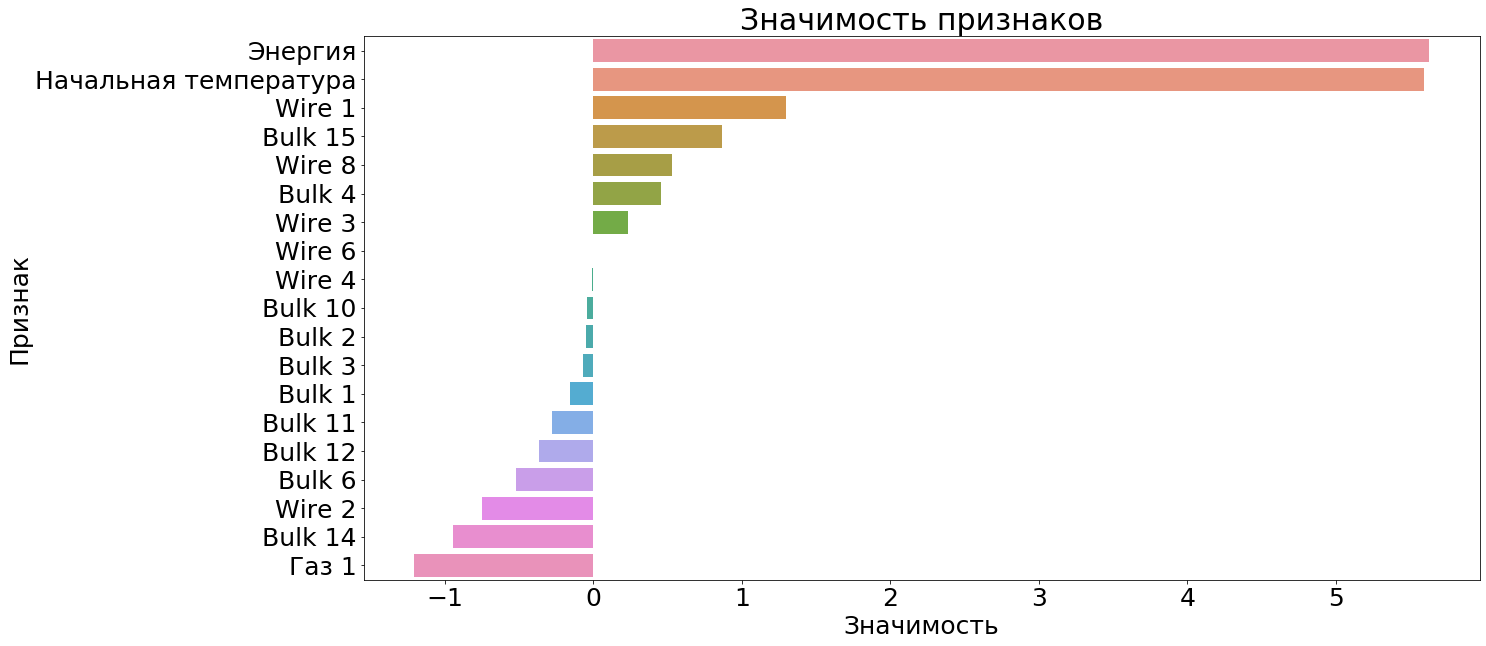

In [28]:
# Посмотрим на значимость признаков у линейной регрессии
feature_imp = pd.DataFrame(sorted(zip(LR.coef_,features.columns)), 
                           columns=['Values','Features'])

plt.figure(figsize=(20, 10))
plt.rcParams['font.size'] = '25'
sns.barplot(x="Values", y="Features", data=feature_imp.sort_values(by="Values", ascending=False))
plt.xlabel("Значимость")
plt.ylabel("Признак")
plt.title('Значимость признаков')
display(feature_imp.sort_values(by="Values", ascending=False))

,Values,Features
18,92,Энергия
17,83,Начальная температура
16,42,Wire 1
15,33,Газ 1
14,32,Bulk 14
13,14,Bulk 12
12,13,Wire 2
11,12,Bulk 15
10,10,Bulk 6
9,7,Bulk 4


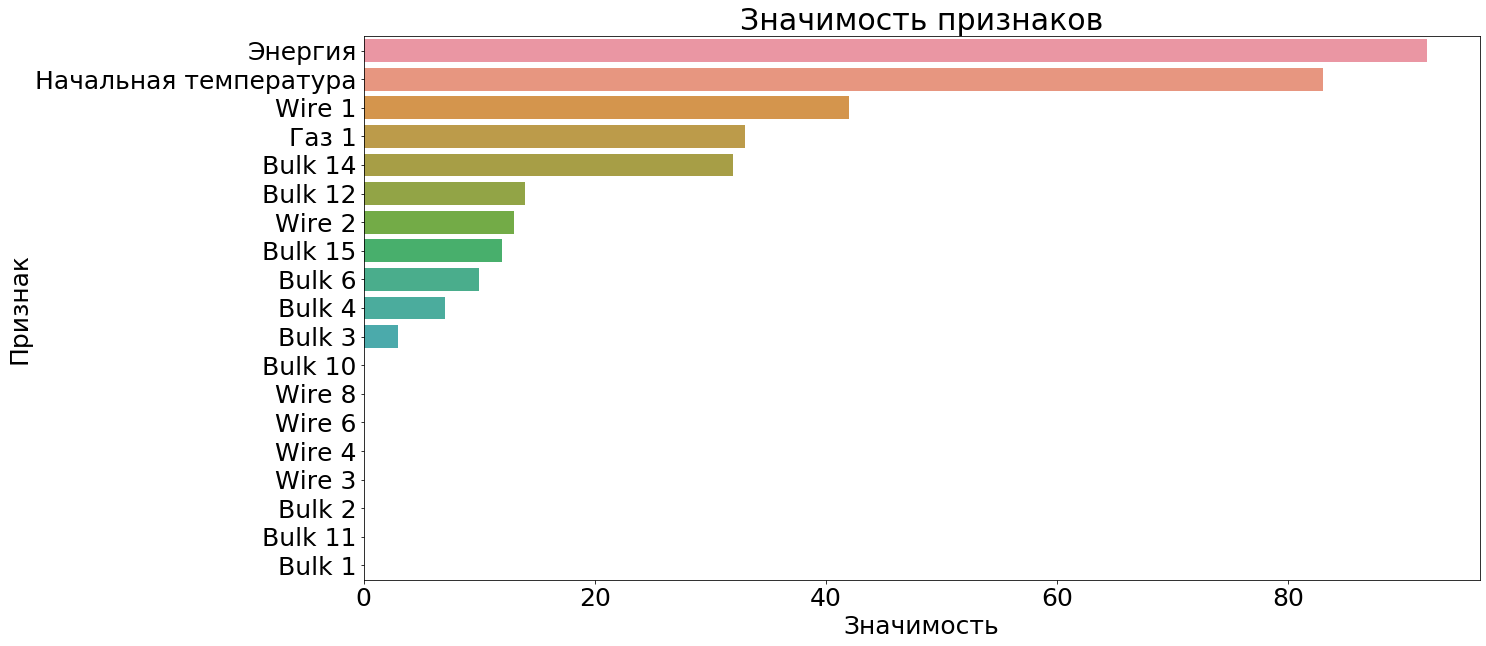

In [29]:
# Посмотрим на значимость признаков у градиентного бустинга
feature_imp = pd.DataFrame(sorted(zip(LGBM.feature_importances_,features.columns)), 
                           columns=['Values','Features'])

plt.figure(figsize=(20, 10))
plt.rcParams['font.size'] = '25'
sns.barplot(x="Values", y="Features", data=feature_imp.sort_values(by="Values", ascending=False))
plt.xlabel("Значимость")
plt.ylabel("Признак")
plt.title('Значимость признаков')
display(feature_imp.sort_values(by="Values", ascending=False))

**Выводы:** Лучшие показатели имеют модели градиентного бустинга и линейной регрессии со значениеми MAE 5,6 и 5,8 градусов. Линейная регрессия не дообучилась, согласно значениям метрики на тренировочной и тестовой выборках. В свою очередь градиентный бустинг показывает почти одинаковые результаты на обеих выборках. Стоит отметить, что лучшая конфигурация градиентного бустинга имеет деревья глубиной 1.

Среди всех признаков наиболее значимы для обеих моделей - энергия и начальная температура. Видно, что часть признаков вообще не имеет значимости.

Анализ коэффициентов линейной регресии также показывает, какие признаки влияют положительно на конечную температуру, а какие отрицательно.

## Какие ключевые шаги в решении задачи выделили?

Основные шаги:
1. Правильное определение и выделение целевого признака
1. Определение и обработка выбросов
2. Удаление ненужных\неинформативных признаков и записей
3. Создание новых признаков
5. Определение оптимальных гиперпараметров моделей
6. Определение значимости признаков

## Какая ваша итоговая модель и какое у неё качество?

Лучшими показателями обладают модели линейной регрессии (*MAE*=5.6) и градиентного бустинга (*MAE*=5.8). Однако, я бы выбрал модель градиентного бустинга для предсказания температуры, так как линейная регрессия слегка не дообучилась на тренировочной выборке. Модель линейной регрессии обладает несколькими приемуществами: 1) по ней можно сказать положительно или отрицательно плияет тот или иной признак на целевой; 2) Если на вход подать значения признаков вне диапазона, на которой обучалась модель, линейная регрессия сможет экстраполировать результаты, в отличии от градиентного бустинга, который будет давать одинаковые значения для всех выбросов.

Хочу также отметить, что определние выбросов также влияет на модели при обучении. Если границы выбросов ставить небольшими (использовать маленький коэффициент при *IQR*), то мы теряем ,возможно, допустимые значения признаков, разброс целевой переменной снижается и модели проще подогнать ответ.
В обратном случае в выборке возникнут значения, которые не соответсвуют основной зависимости и моедль не сможет качественно обучится.